In [ ]:
!rm -rf *
!curl -u leprieto:{SECRET} -o dataset.zip "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/00_clean_filtered_dataset/dataset.zip"
!unzip -q dataset.zip
!rm dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  15.9M      0  0:00:12  0:00:12 --:--:-- 19.3M


In [ ]:
import keras
import tensorflow as tf
from keras.applications import DenseNet121
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, display
from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight
import os

In [ ]:

image_size = (300, 300)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "dataset/casting_data/casting_data/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
    )

train_ds = train_ds.map(lambda x, y: (keras.applications.densenet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (keras.applications.densenet.preprocess_input(x), y))

Found 6569 files belonging to 2 classes.
Using 5256 files for training.
Using 1313 files for validation.


In [ ]:
basemodel = DenseNet121(weights = 'imagenet', include_top = False,
                        input_shape = (300, 300, 3), pooling = None)

# for layer in basemodel.layers:
#   layer.trainable = False

x = tf.keras.layers.Flatten()(basemodel.output)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2, activation = 'softmax')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy',
          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
         metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                   tf.keras.metrics.Recall(name = 'recall')])

m.summary()

hist = m.fit(train_ds, epochs = 100, batch_size = 32,
             validation_data = val_ds,
             callbacks = [
                tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss', mode = 'min', restore_best_weights = True),
                tf.keras.callbacks.ReduceLROnPlateau(patience = 6, monitor = 'val_loss', mode = 'min', factor = 0.1)
            ],
             )

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 306, 306,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 75, 75,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 75, 75,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 75, 75,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 75, 75,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 75, 75,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 75, 75,    │     12,288 │ conv2_block2_0_r

 Total params: 8,696,498 (33.17 MB)

 Trainable params: 8,446,930 (32.22 MB)

 Non-trainable params: 249,568 (974.88 KB)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.7889 - loss: 0.5780 - precision: 0.7889 - recall: 0.7889 - val_accuracy: 0.7936 - val_loss: 0.4073 - val_precision: 0.7936 - val_recall: 0.7936 - learning_rate: 1.0000e-04
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 87s 526ms/step - accuracy: 0.9774 - loss: 0.3234 - precision: 0.9774 - recall: 0.9774 - val_accuracy: 0.9977 - val_loss: 0.1884 - val_precision: 0.9977 - val_recall: 0.9977 - learning_rate: 1.0000e-04
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 86s 523ms/step - accuracy: 0.9860 - loss: 0.2784 - precision: 0.9860 - recall: 0.9860 - val_accuracy: 0.9985 - val_loss: 0.1732 - val_precision: 0.9985 - val_recall: 0.9985 - learning_rate: 1.0000e-04
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 86s 522ms/step - accuracy: 0.9832 - loss: 0.2519 - precision: 0.9832 - recall: 0.9832 - val_accuracy: 0.9977 - val_loss: 0.1311 - val_precision: 0.9977 - val_recall: 0.9977 - learning_rate: 1.0000e-04
Epoch 5/100
165/165 ━━━━━━━━━━━━━━

Found 715 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

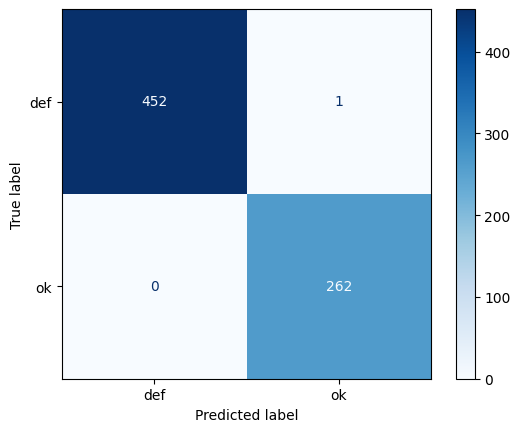

              precision    recall  f1-score   support

         def     1.0000    0.9978    0.9989       453
          ok     0.9962    1.0000    0.9981       262

    accuracy                         0.9986       715
   macro avg     0.9981    0.9989    0.9985       715
weighted avg     0.9986    0.9986    0.9986       715



In [ ]:
test_dataset = image_dataset_from_directory(
    '/content/dataset/casting_data/casting_data/test',
    seed=42,
    image_size=(300,300),
    batch_size=1,
    label_mode='categorical'  # One-hot encoded labels
)

test_dataset = test_dataset.map(lambda x, y: (keras.applications.densenet.preprocess_input(x), y))

# Collect true labels and predictions
true_labels = []
predictions = []

# n = 0
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    batch_pred = m.predict(images)
    predictions.extend(batch_pred)
    # if n == 100:
    #     break
    # n += 1

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Convert one-hot labels and softmax predictions to class indices
true_classes = np.argmax(true_labels, axis=1)
pred_classes = np.argmax(predictions, axis=1)

print(np.bincount(true_classes))


# Generate confusion matrix and classification report
cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['def', 'ok'])
report = classification_report(true_classes, pred_classes, target_names=['def', 'ok'], digits=4)

cm_display.plot(cmap=plt.cm.Blues)
plt.savefig("confusion_matrix.svg")
plt.show()
print(report)

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 300, 300, 3))
  warnings.warn(msg)


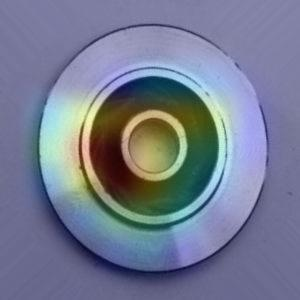

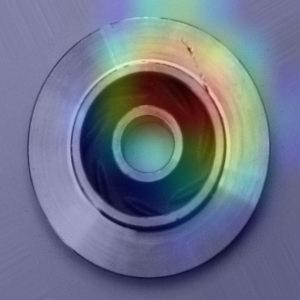

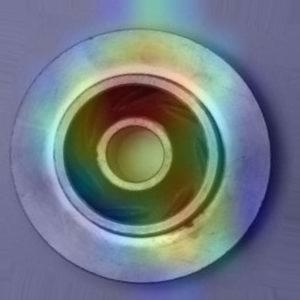

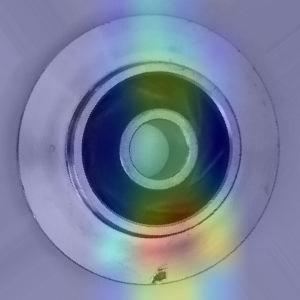

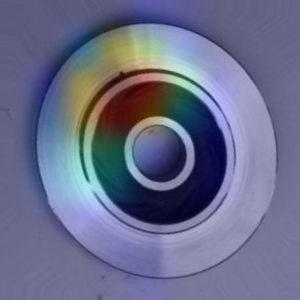

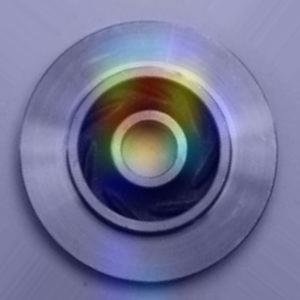

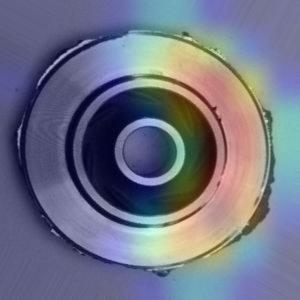

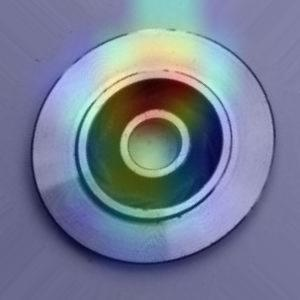

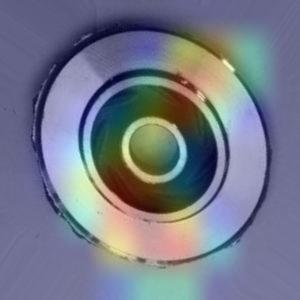

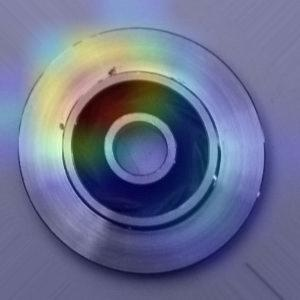

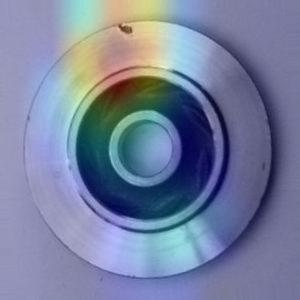

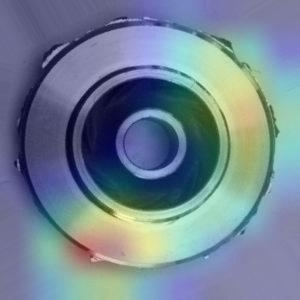

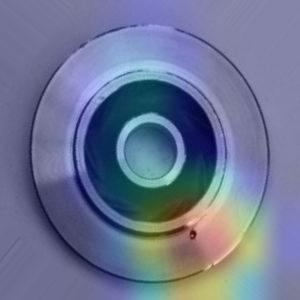

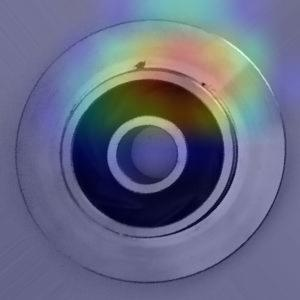

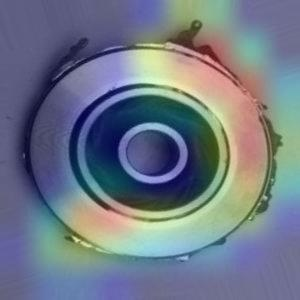

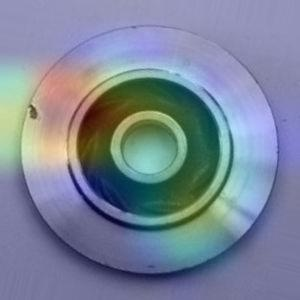

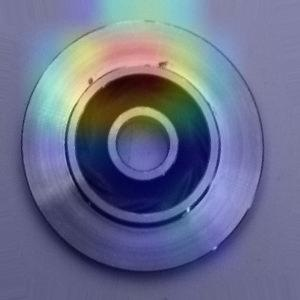

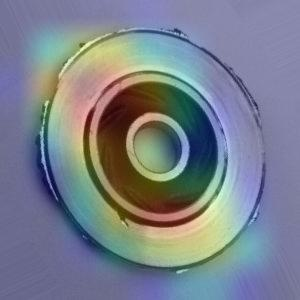

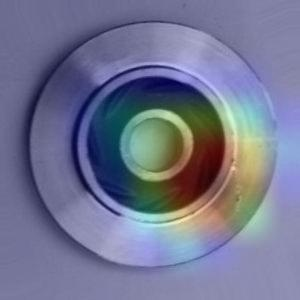

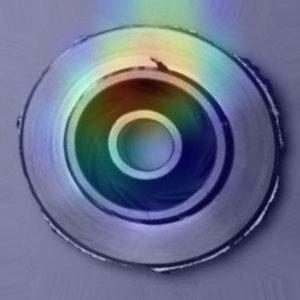

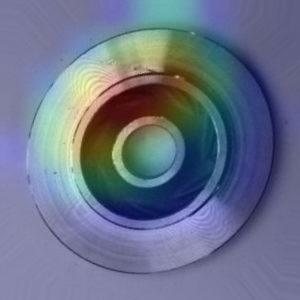

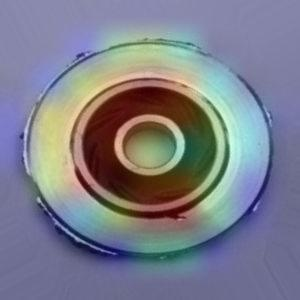

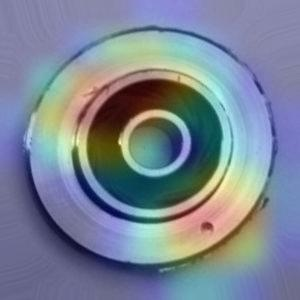

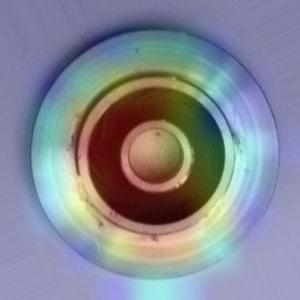

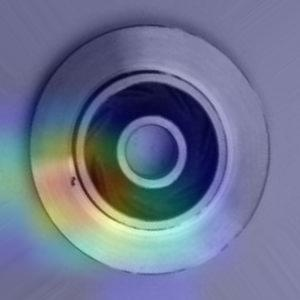

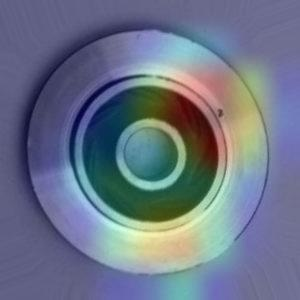

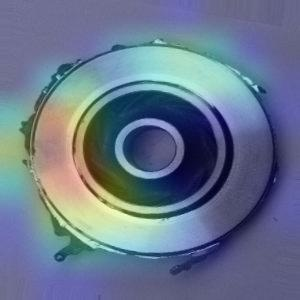

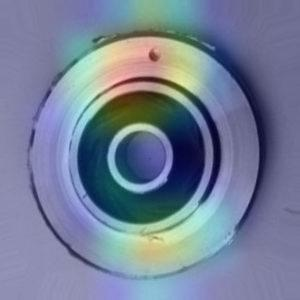

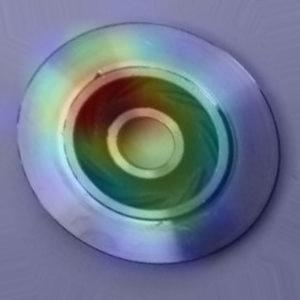

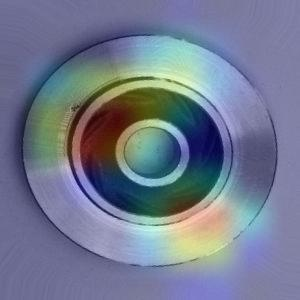

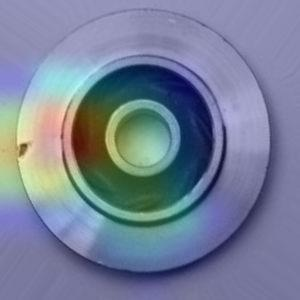

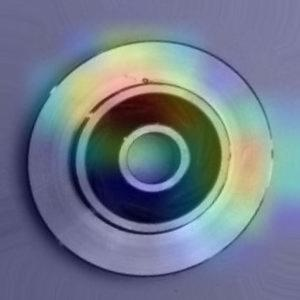

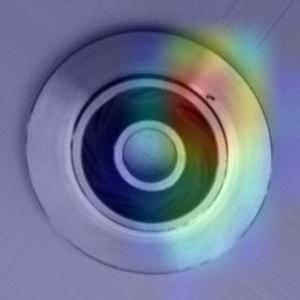

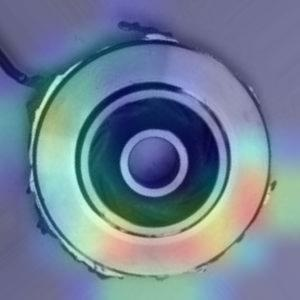

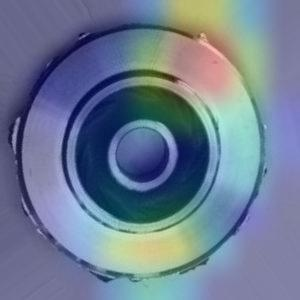

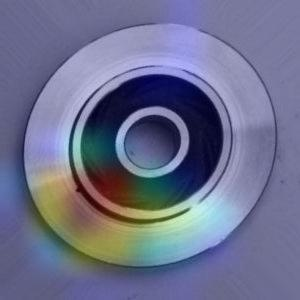

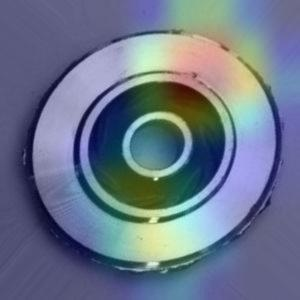

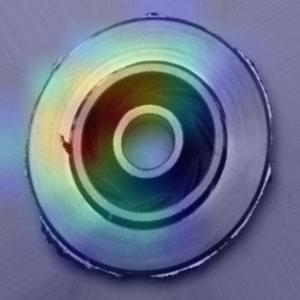

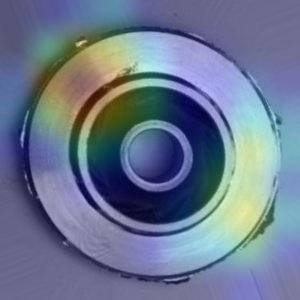

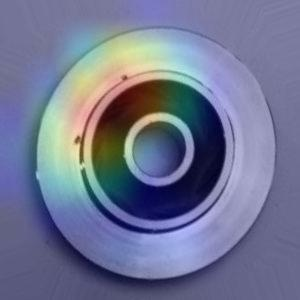

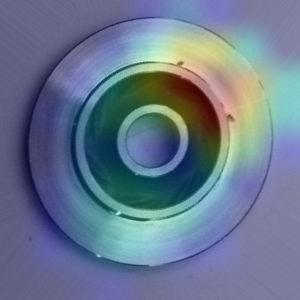

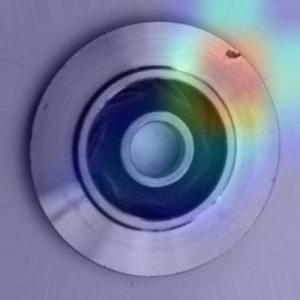

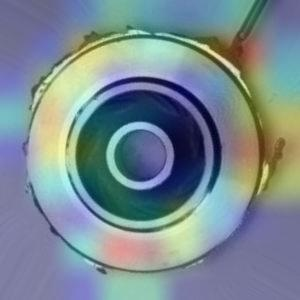

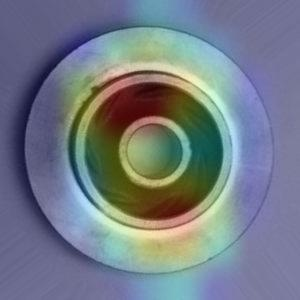

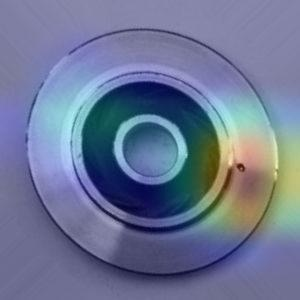

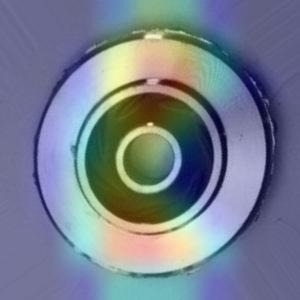

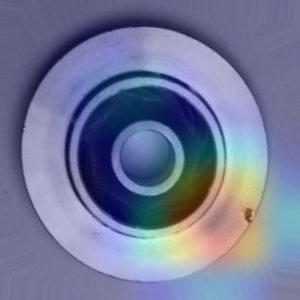

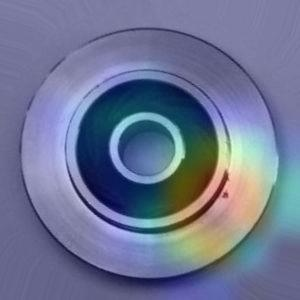

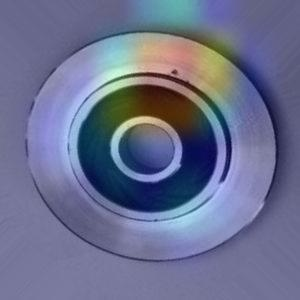

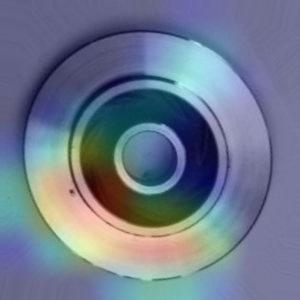

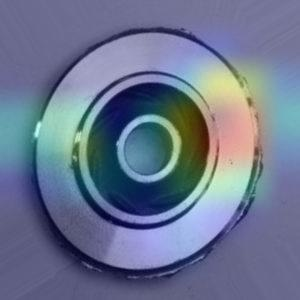

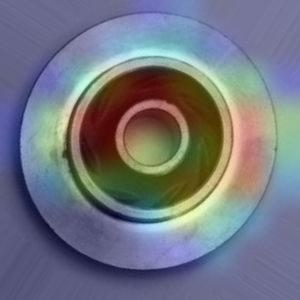

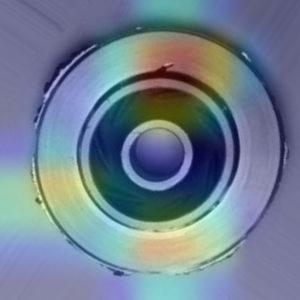

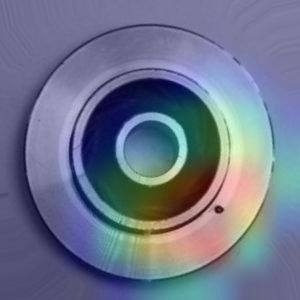

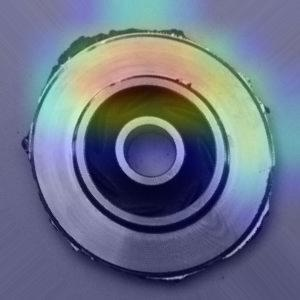

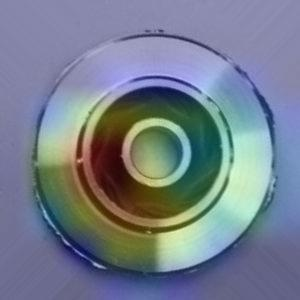

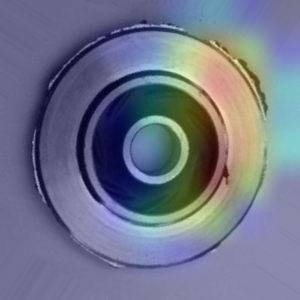

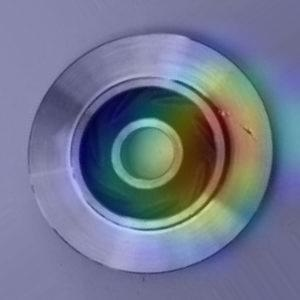

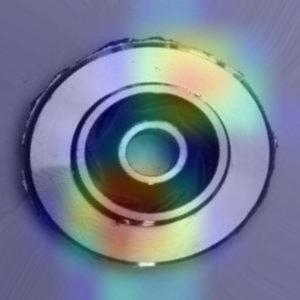

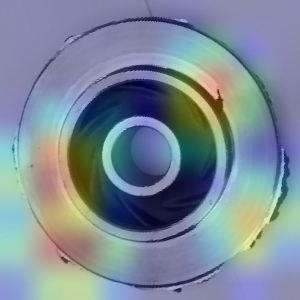

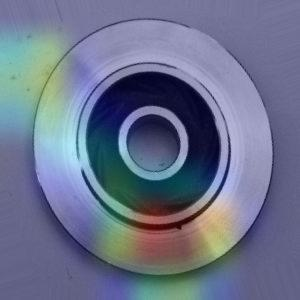

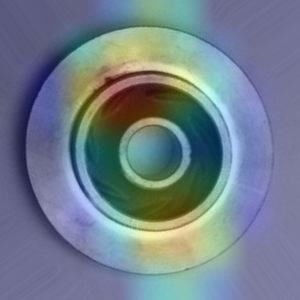

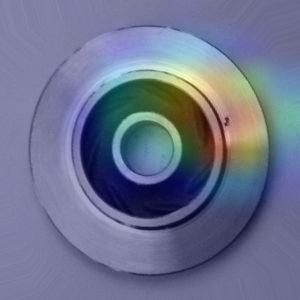

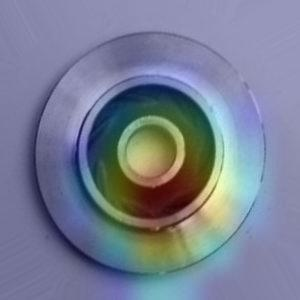

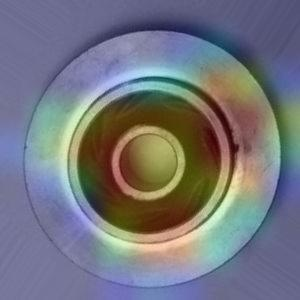

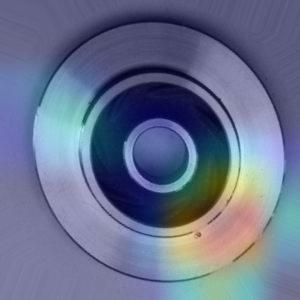

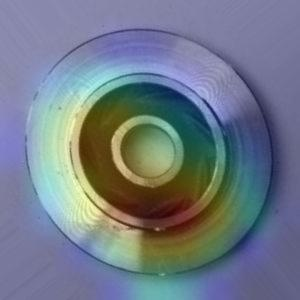

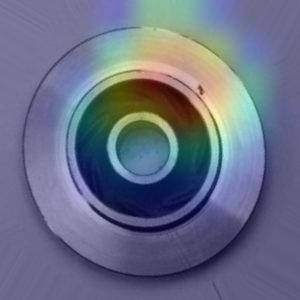

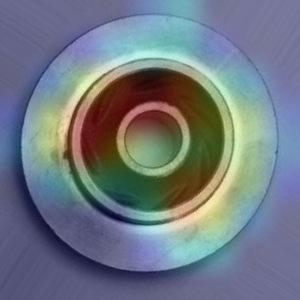

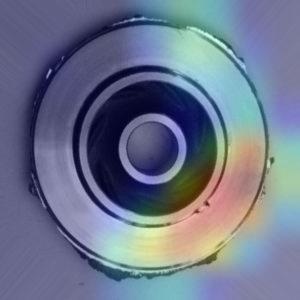

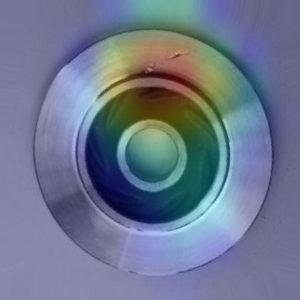

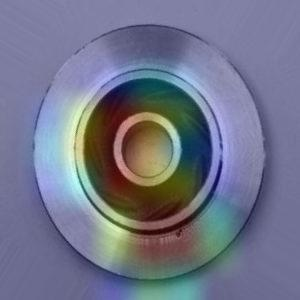

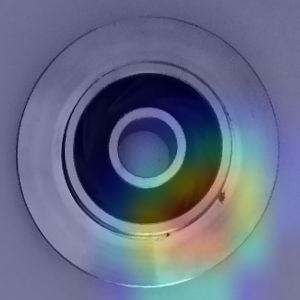

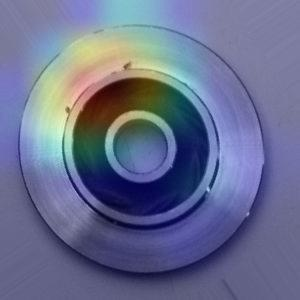

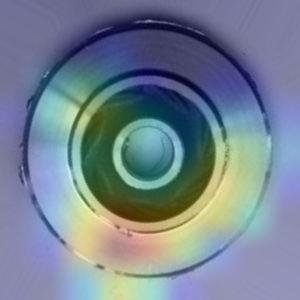

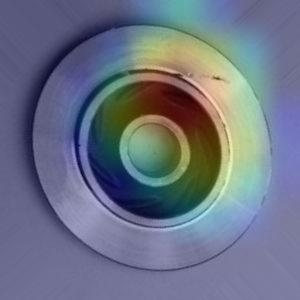

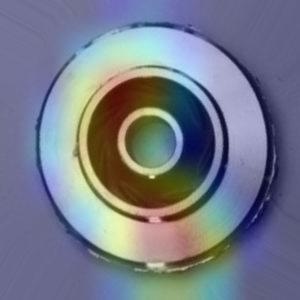

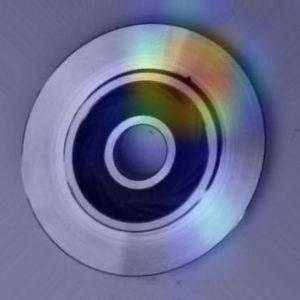

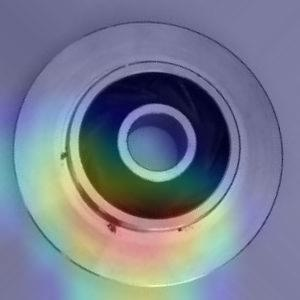

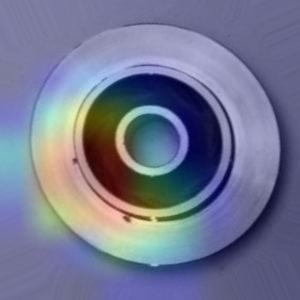

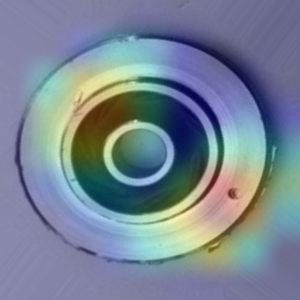

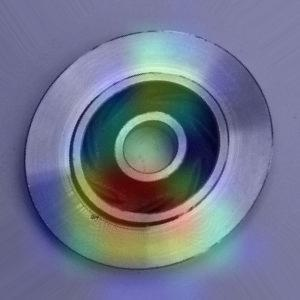

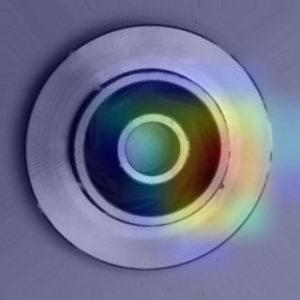

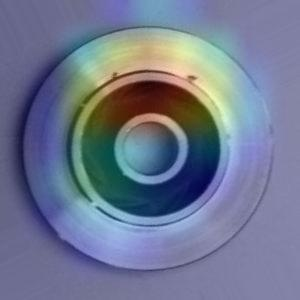

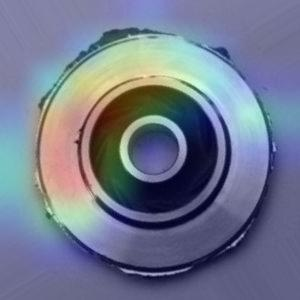

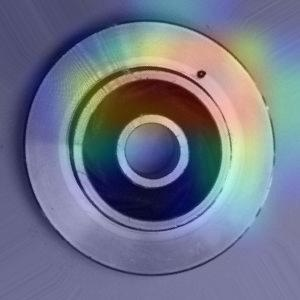

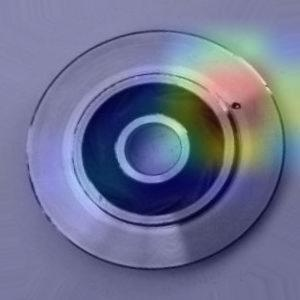

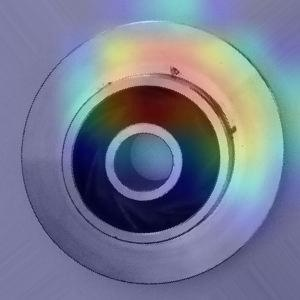

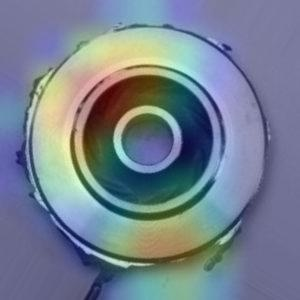

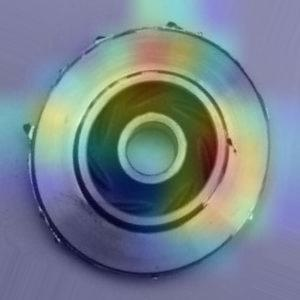

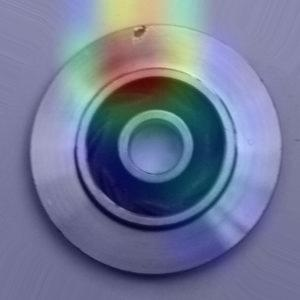

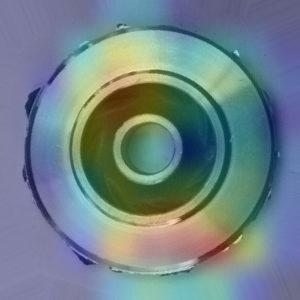

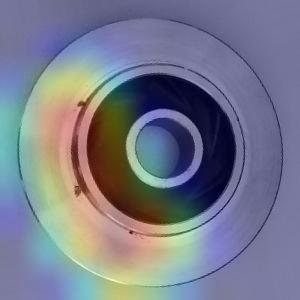

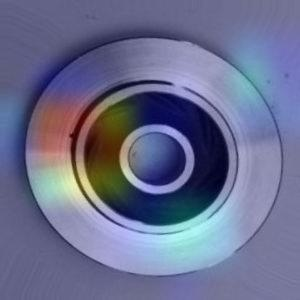

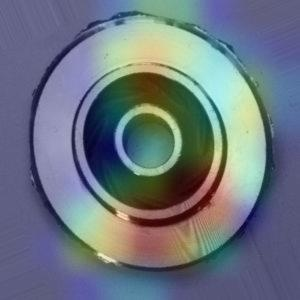

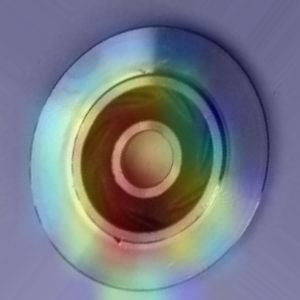

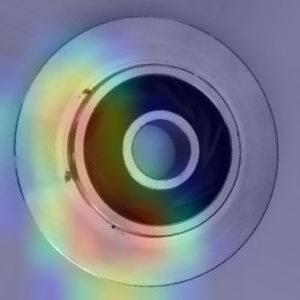

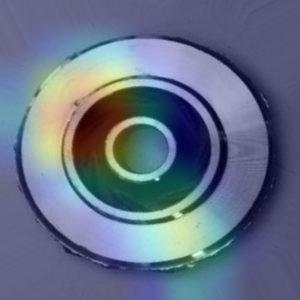

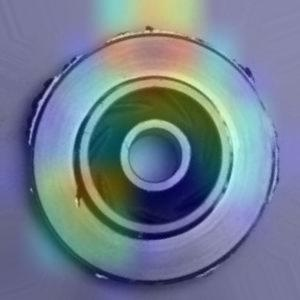

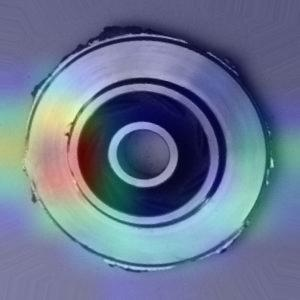

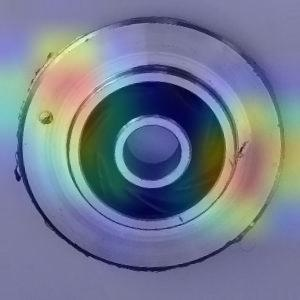

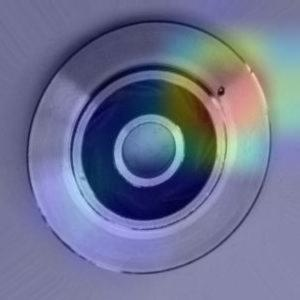

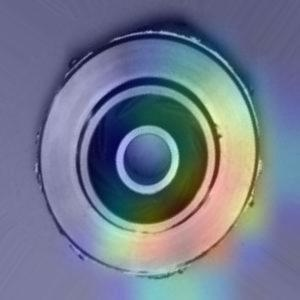

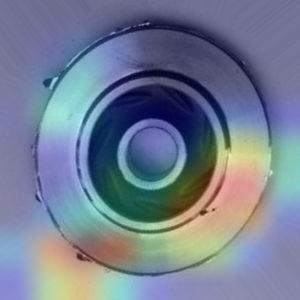

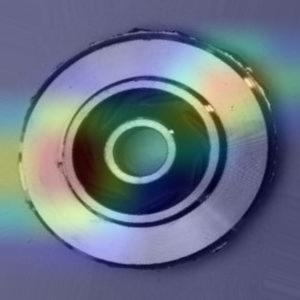

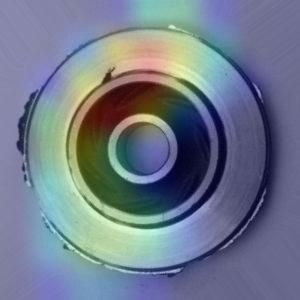

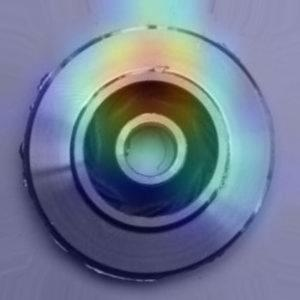

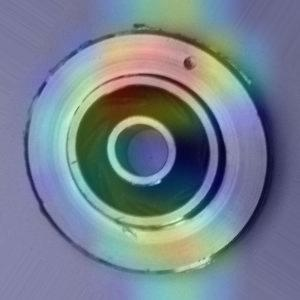

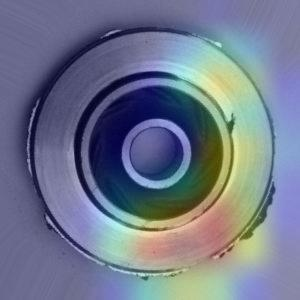

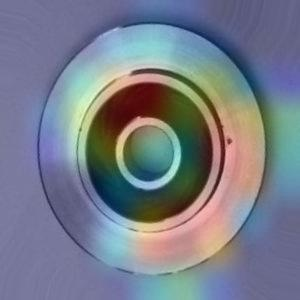

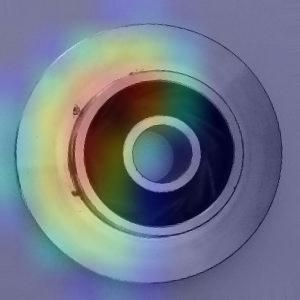

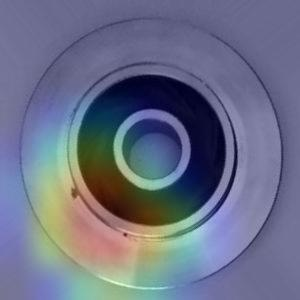

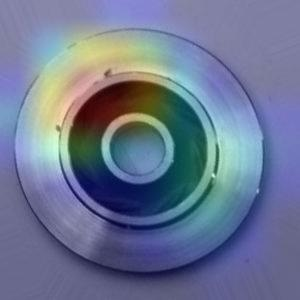

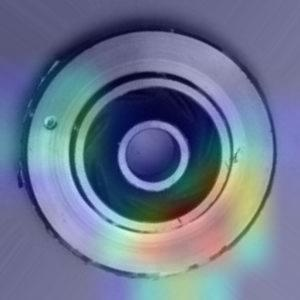

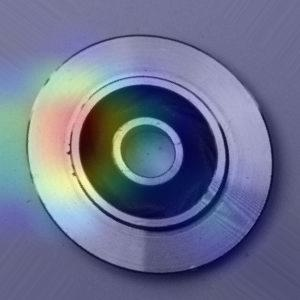

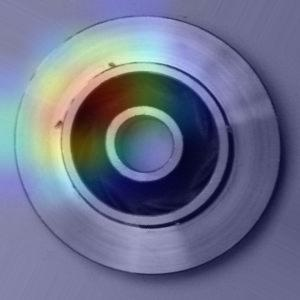

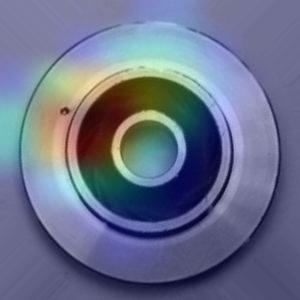

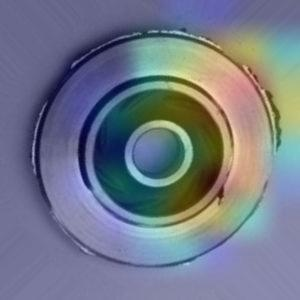

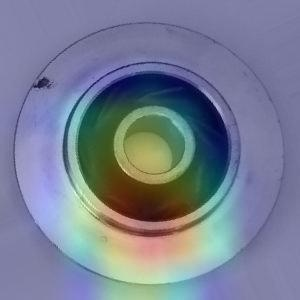

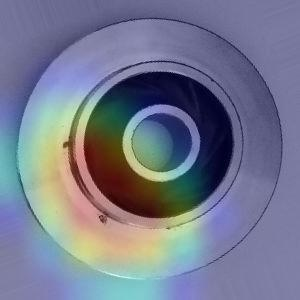

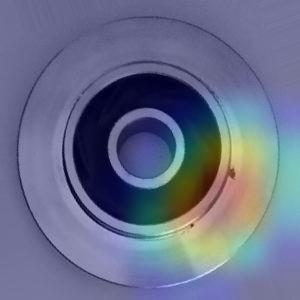

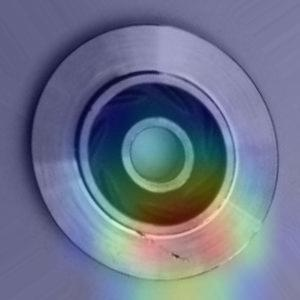

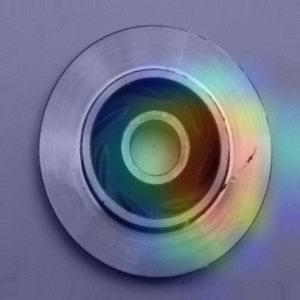

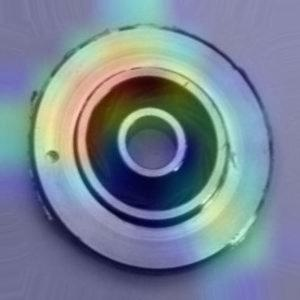

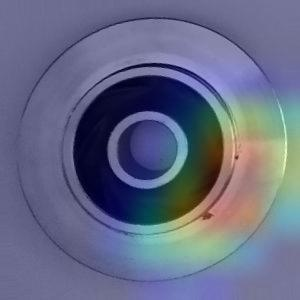

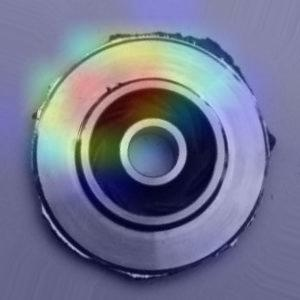

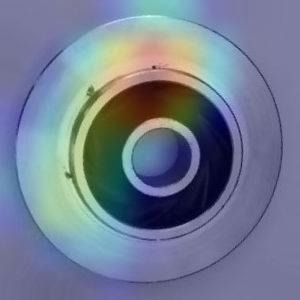

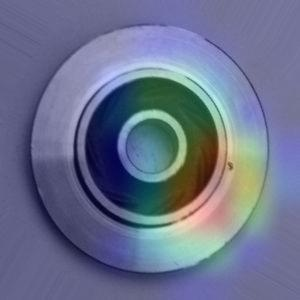

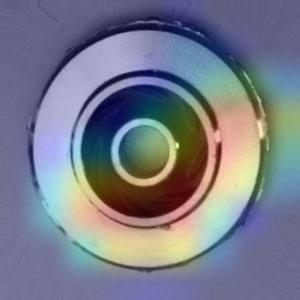

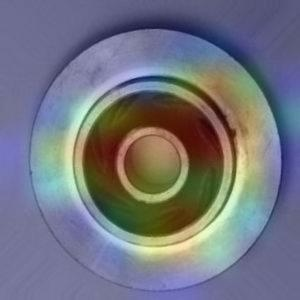

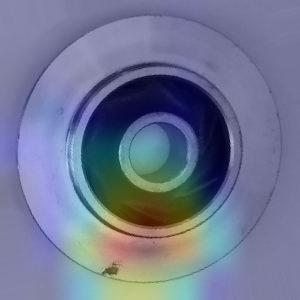

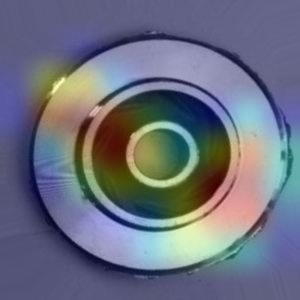

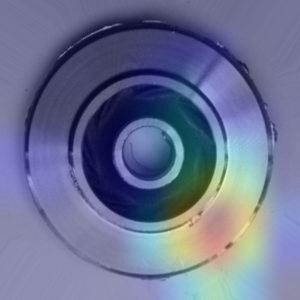

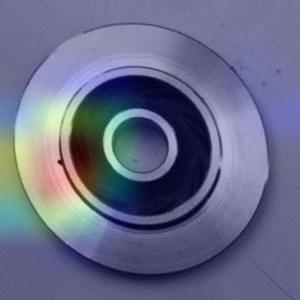

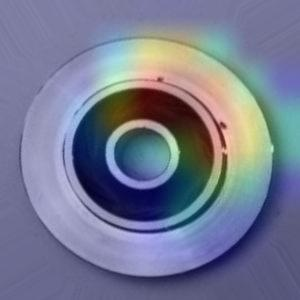

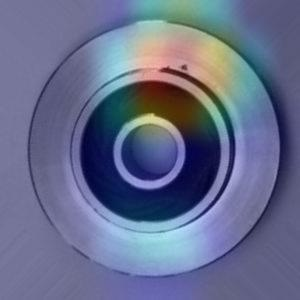

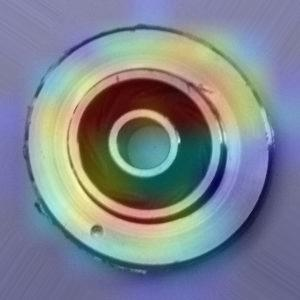

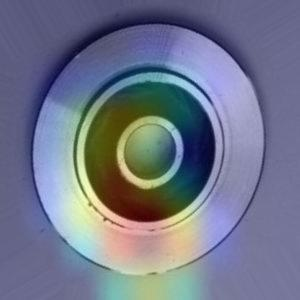

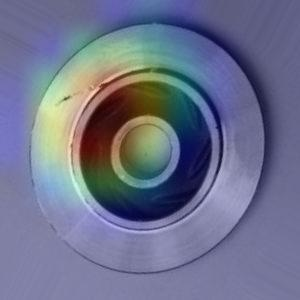

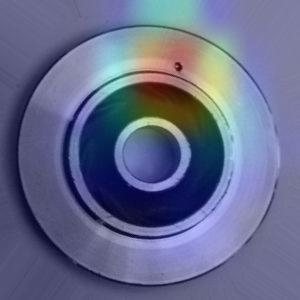

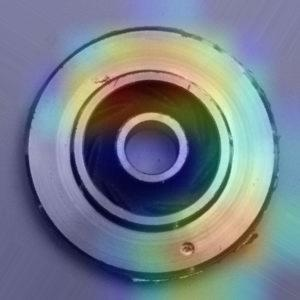

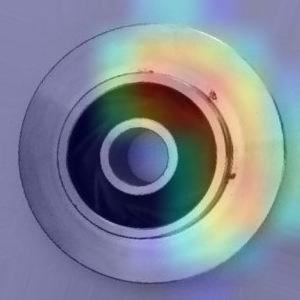

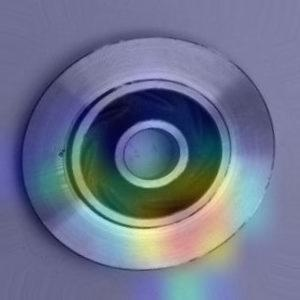

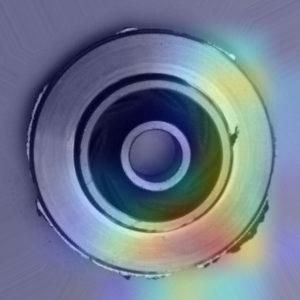

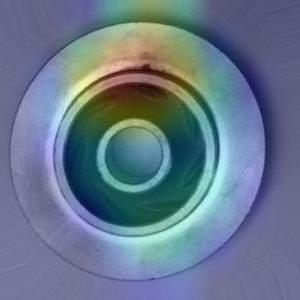

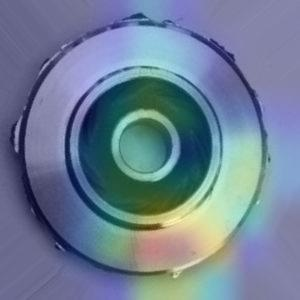

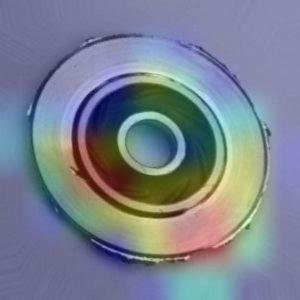

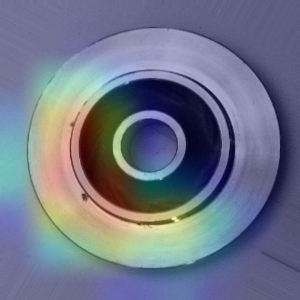

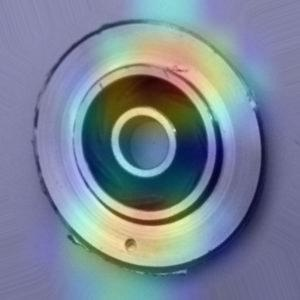

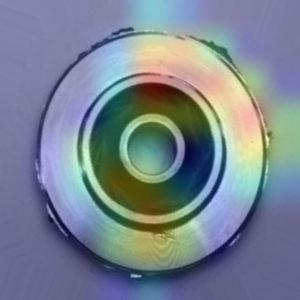

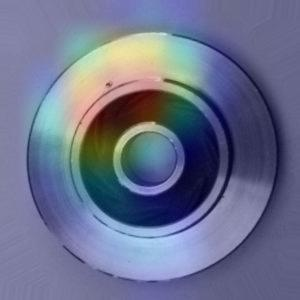

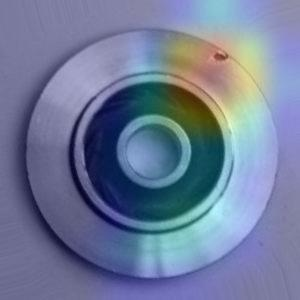

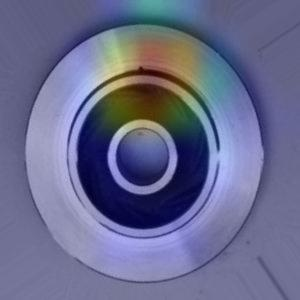

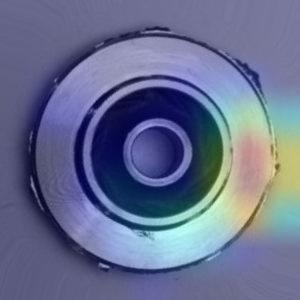

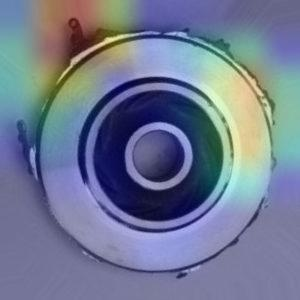

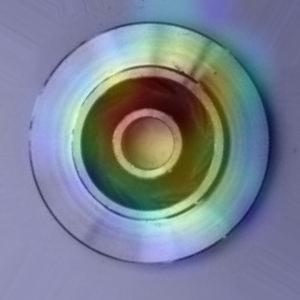

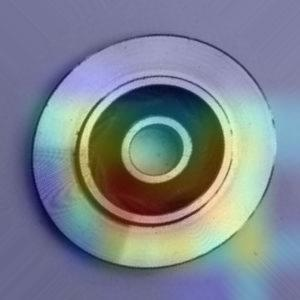

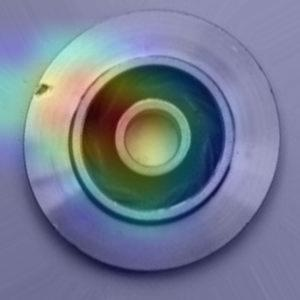

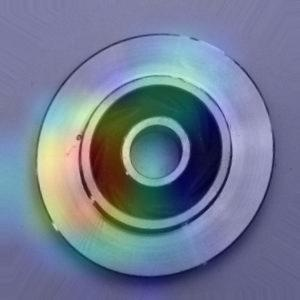

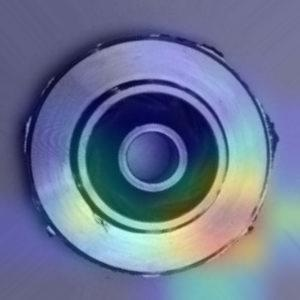

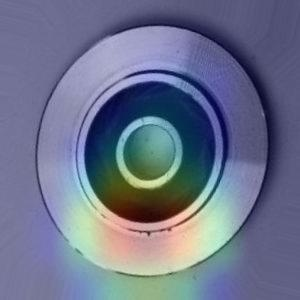

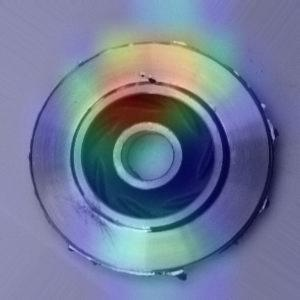

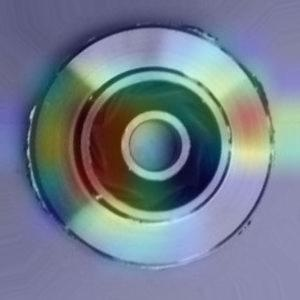

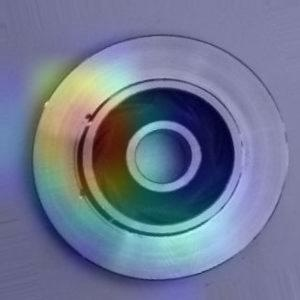

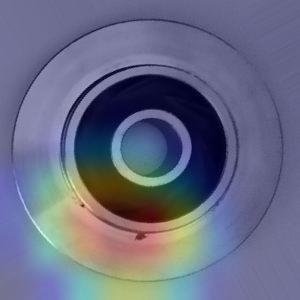

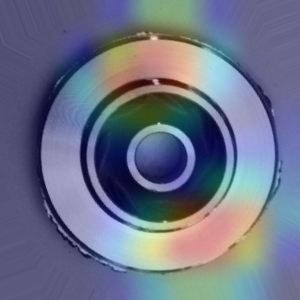

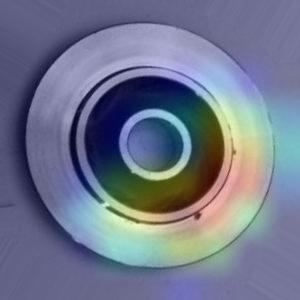

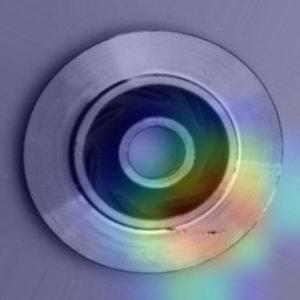

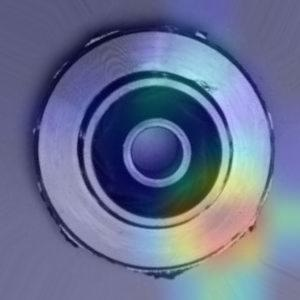

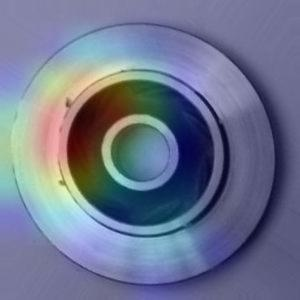

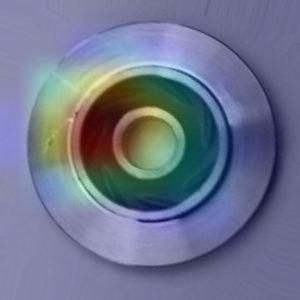

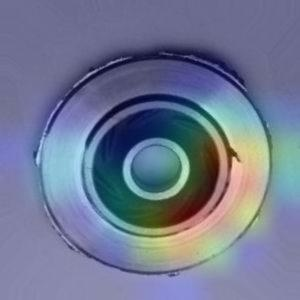

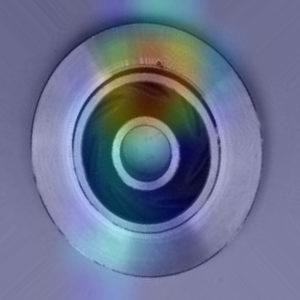

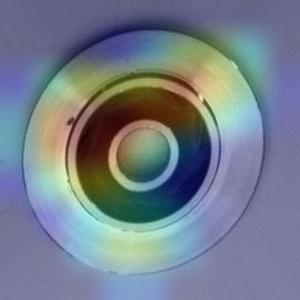

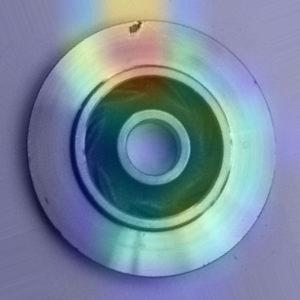

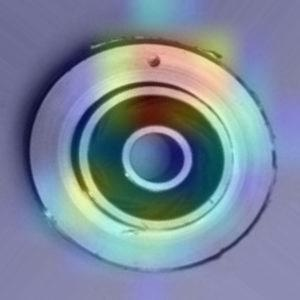

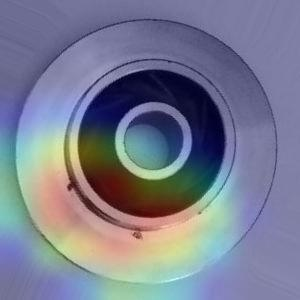

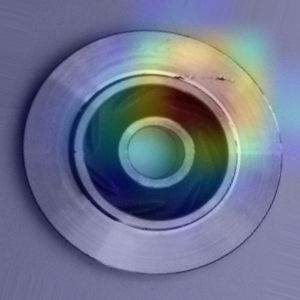

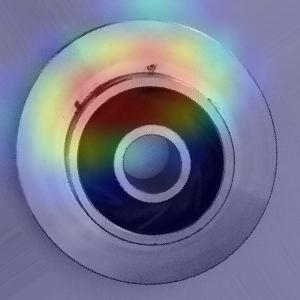

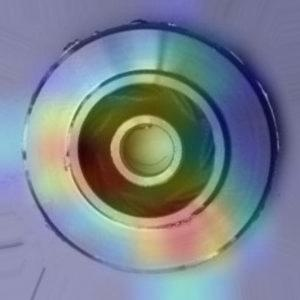

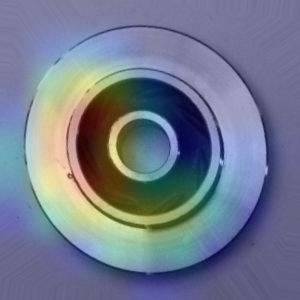

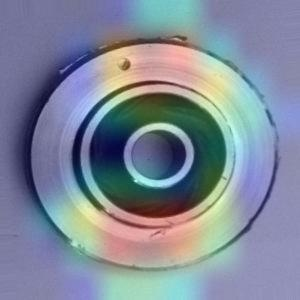

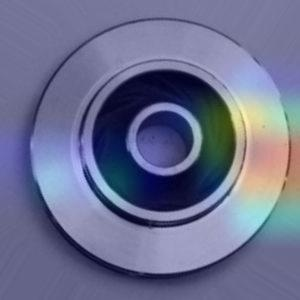

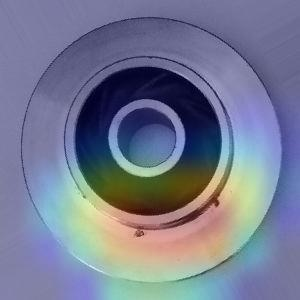

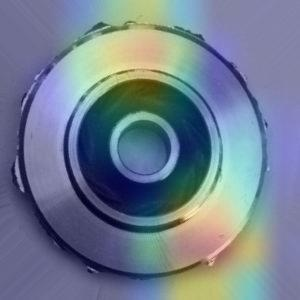

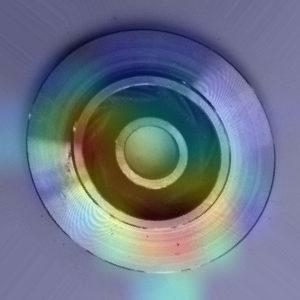

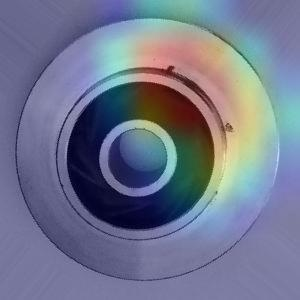

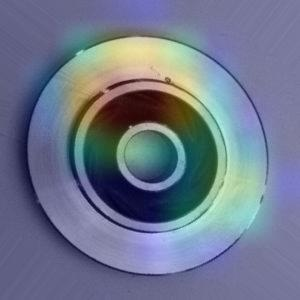

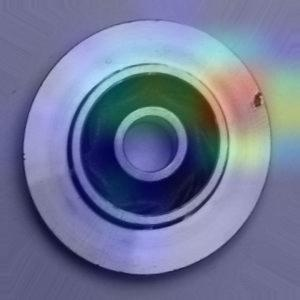

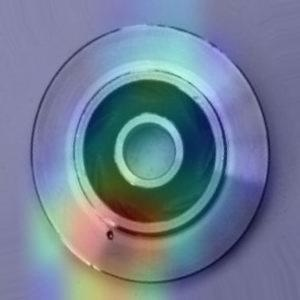

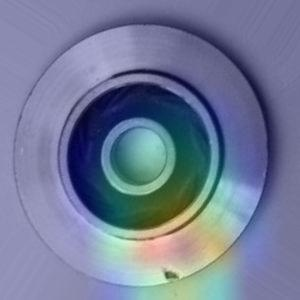

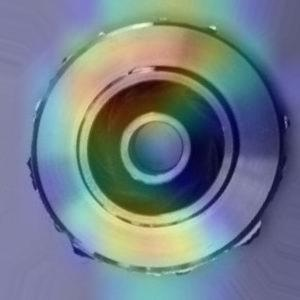

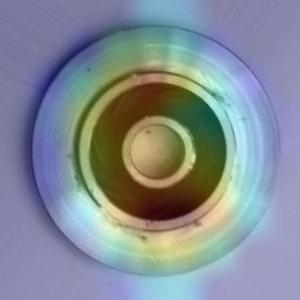

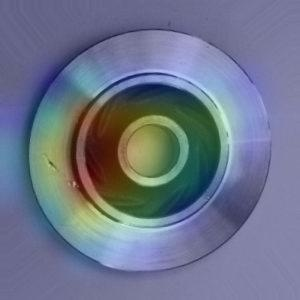

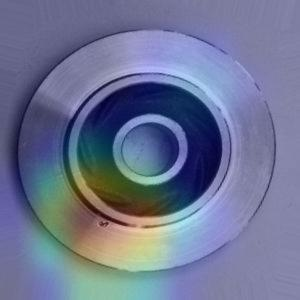

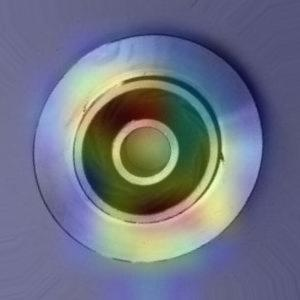

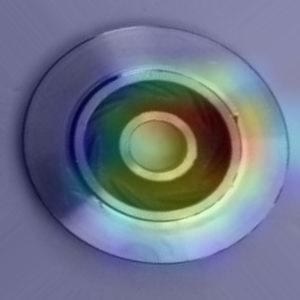

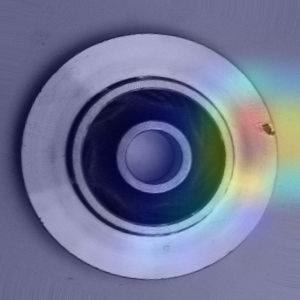

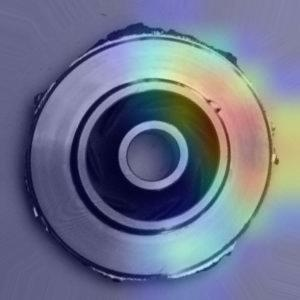

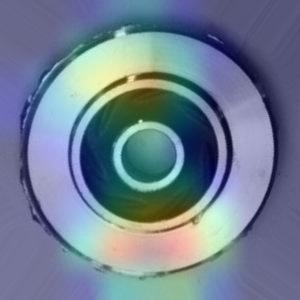

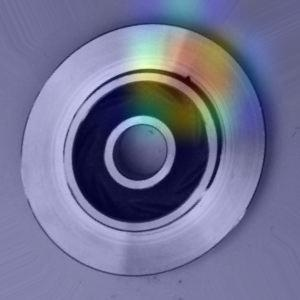

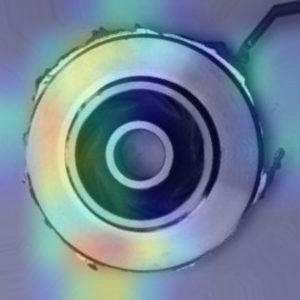

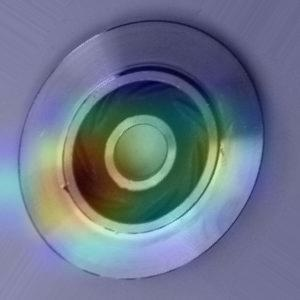

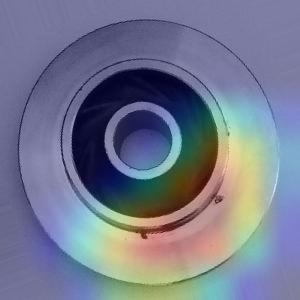

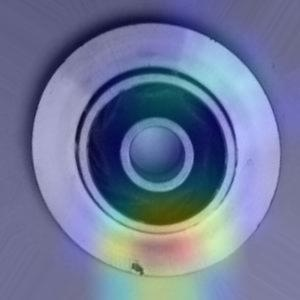

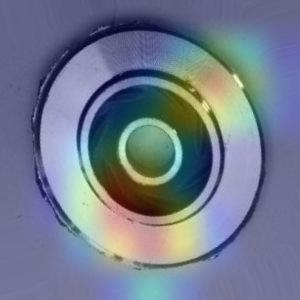

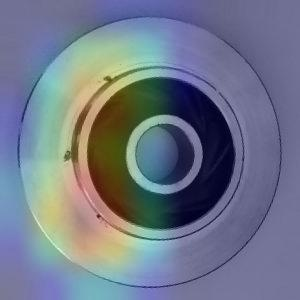

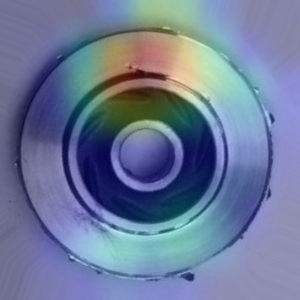

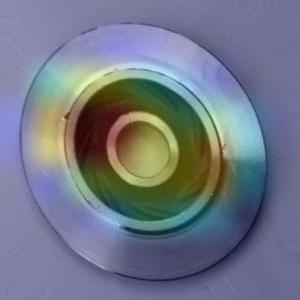

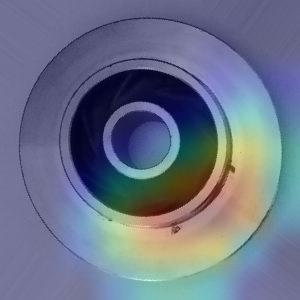

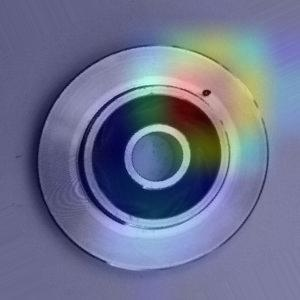

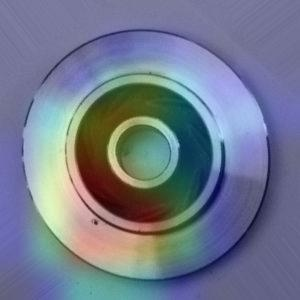

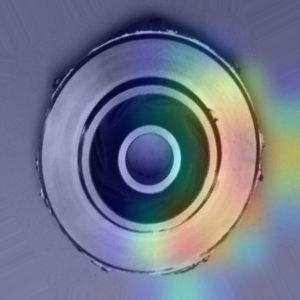

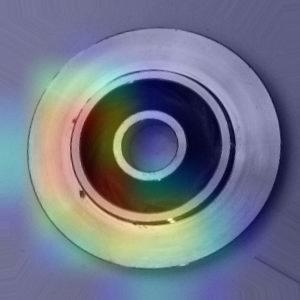

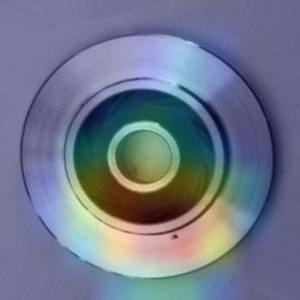

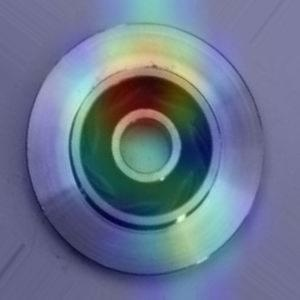

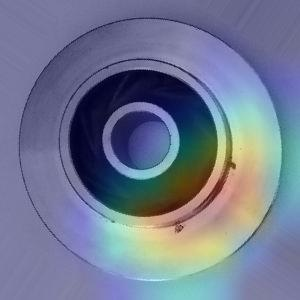

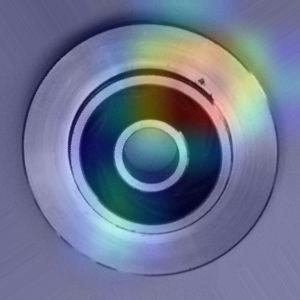

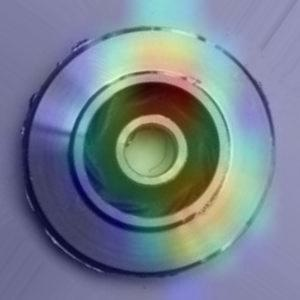

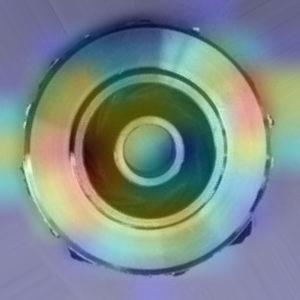

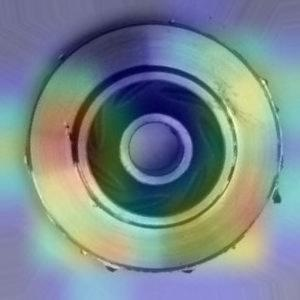

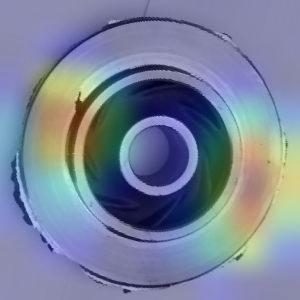

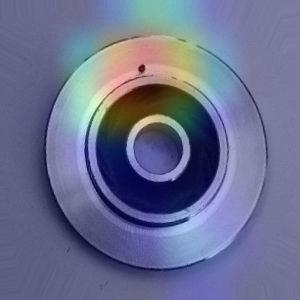

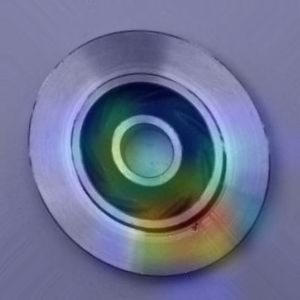

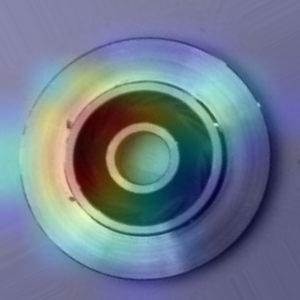

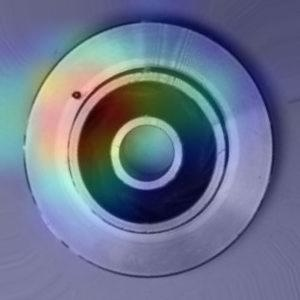

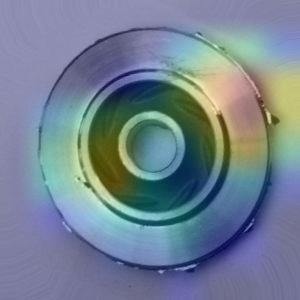

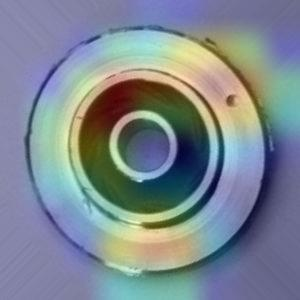

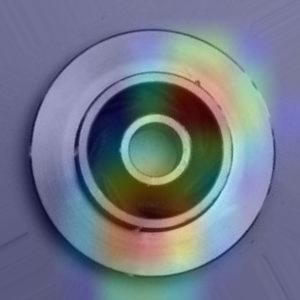

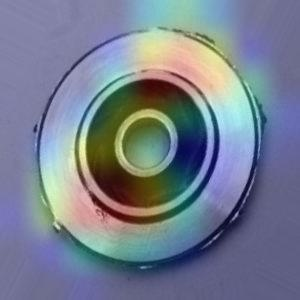

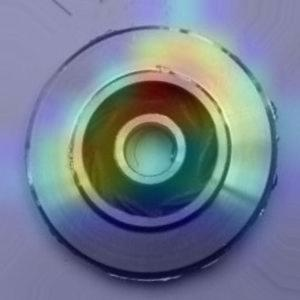

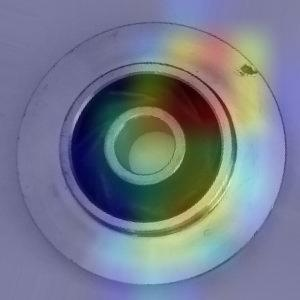

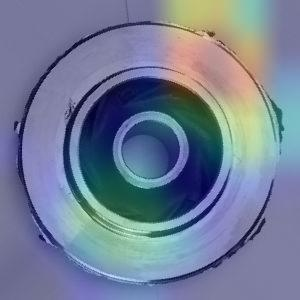

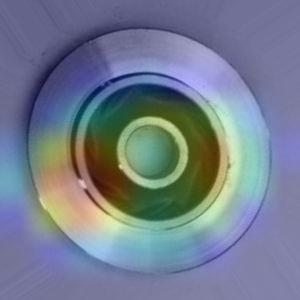

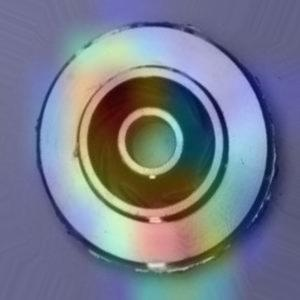

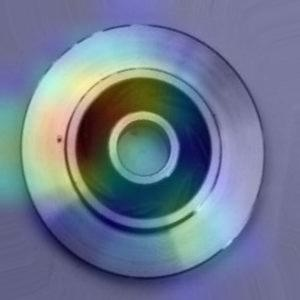

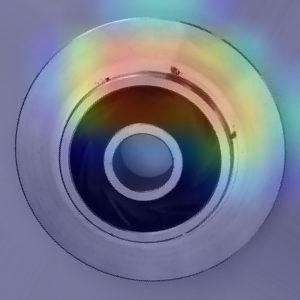

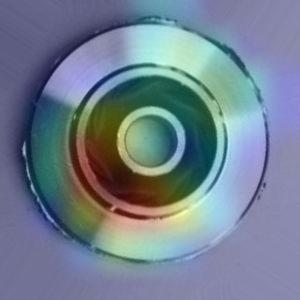

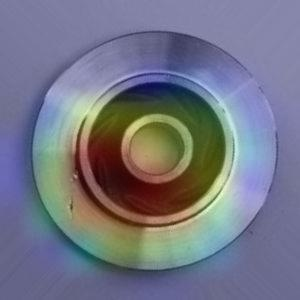

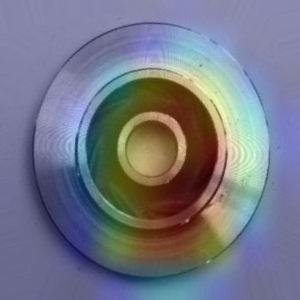

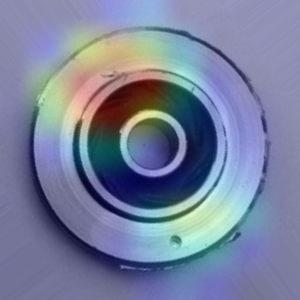

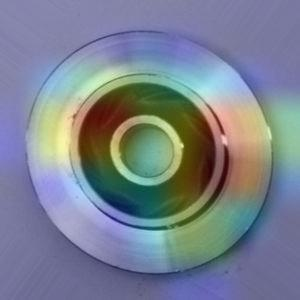

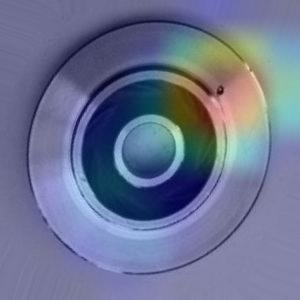

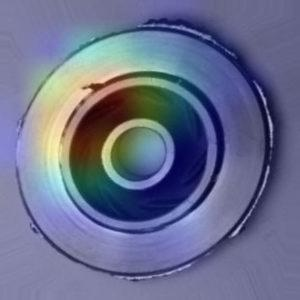

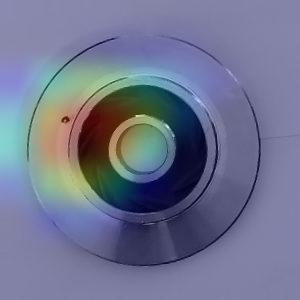

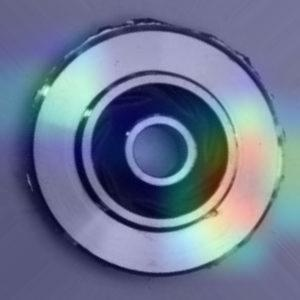

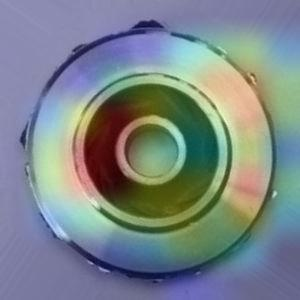

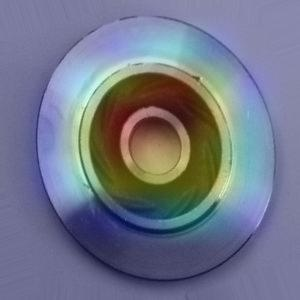

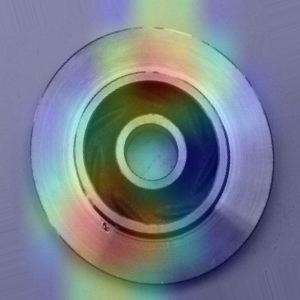

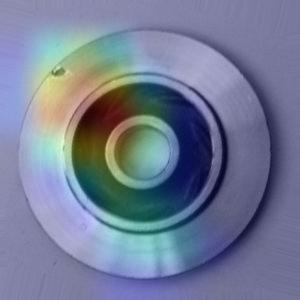

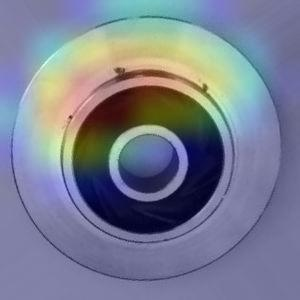

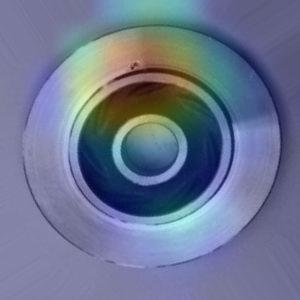

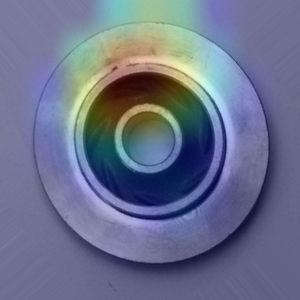

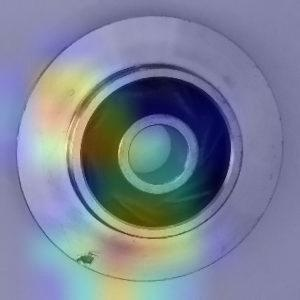

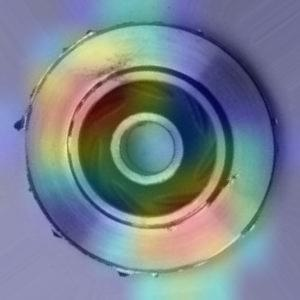

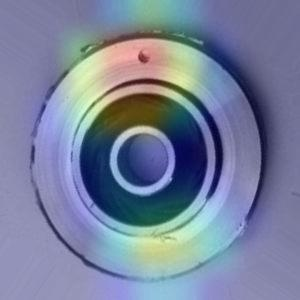

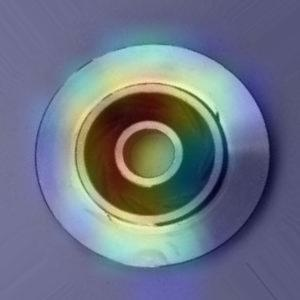

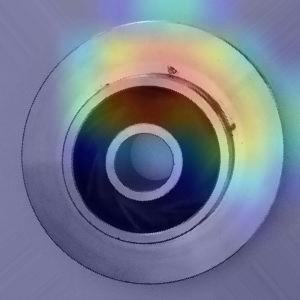

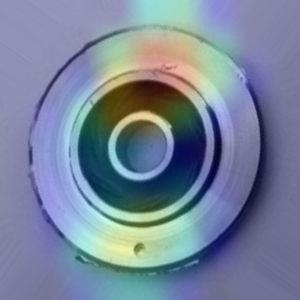

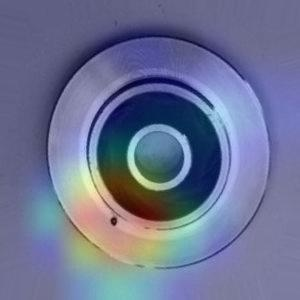

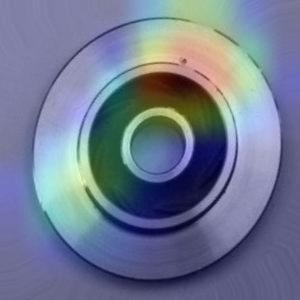

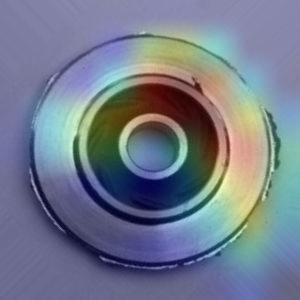

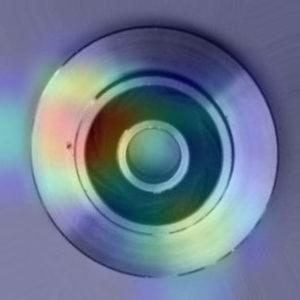

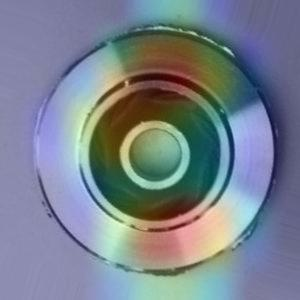

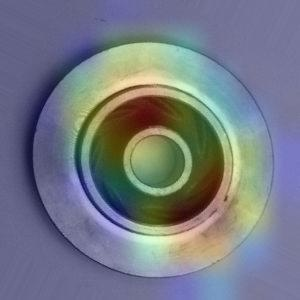

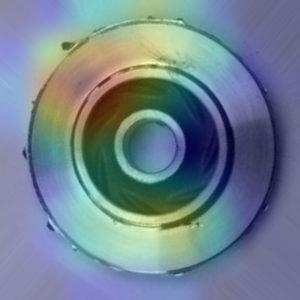

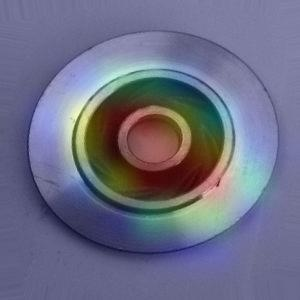

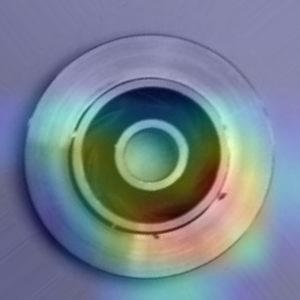

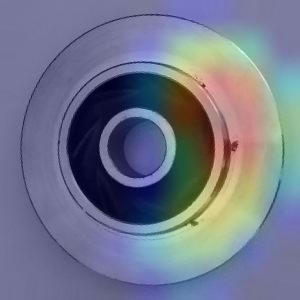

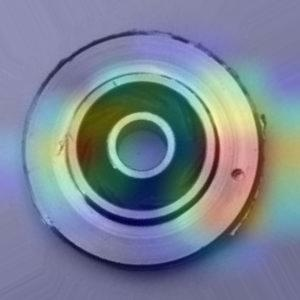

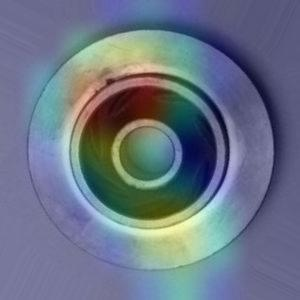

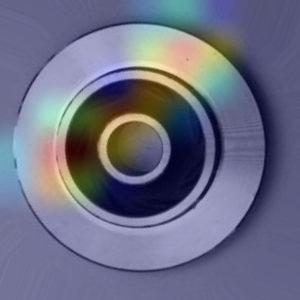

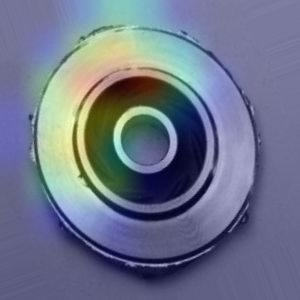

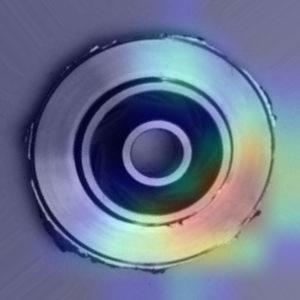

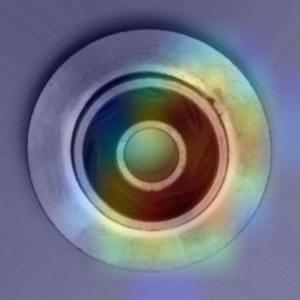

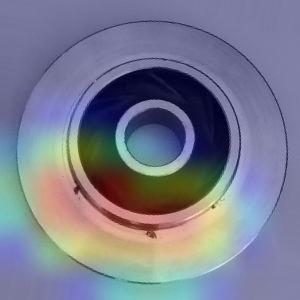

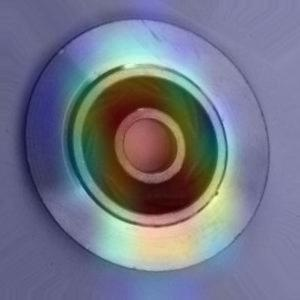

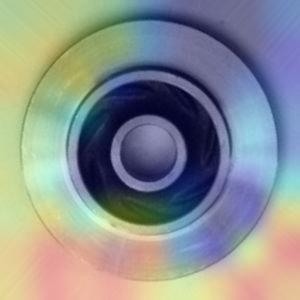

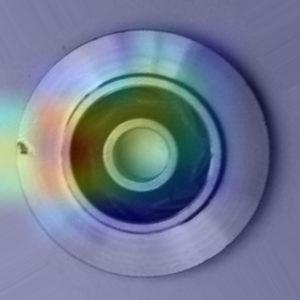

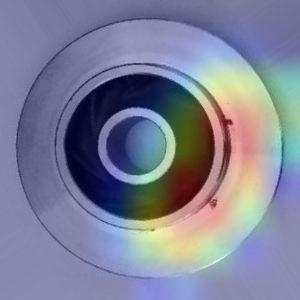

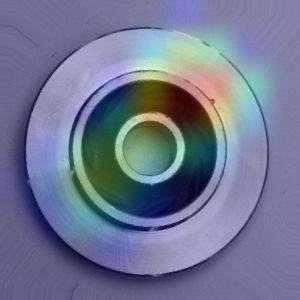

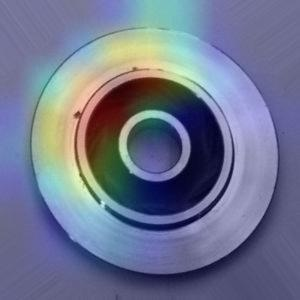

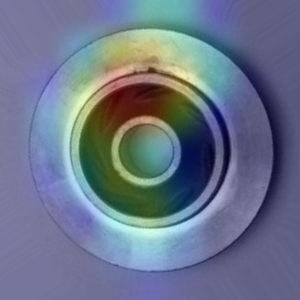

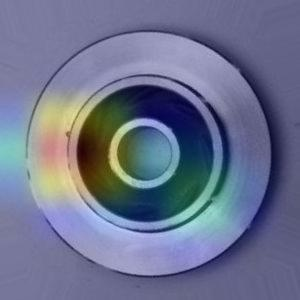

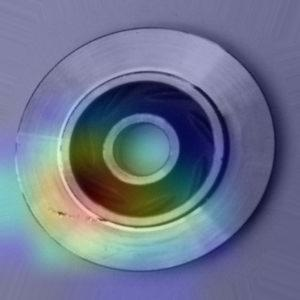

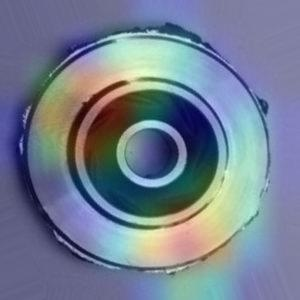

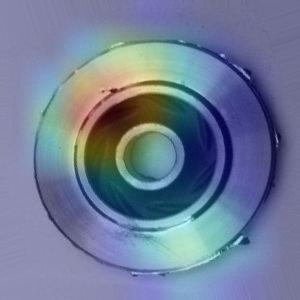

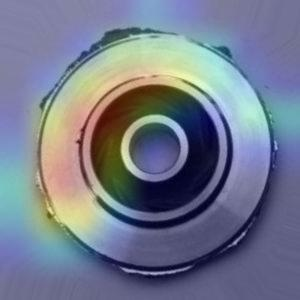

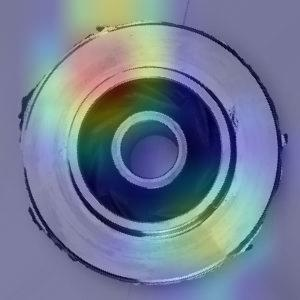

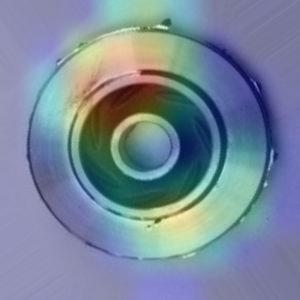

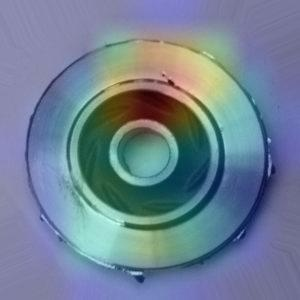

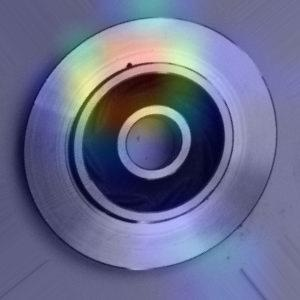

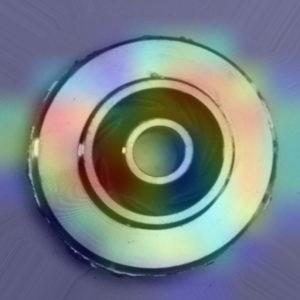

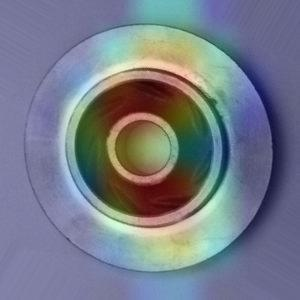

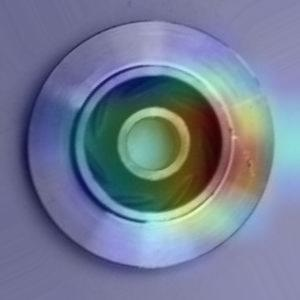

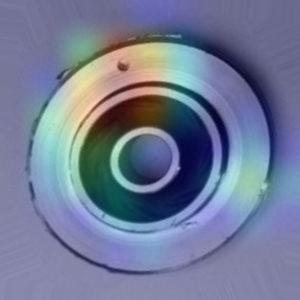

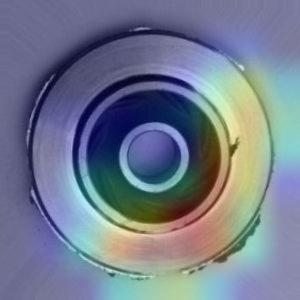

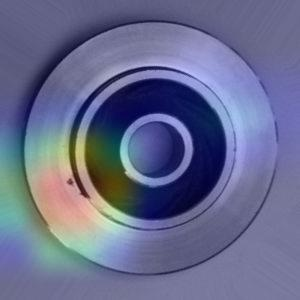

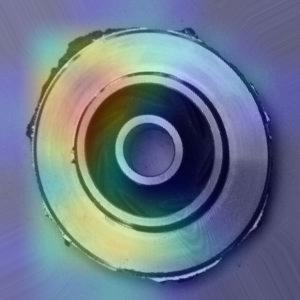

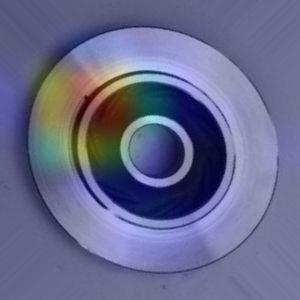

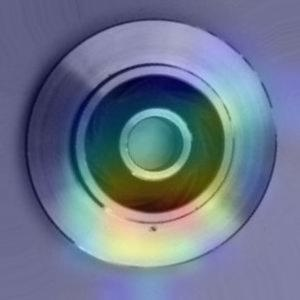

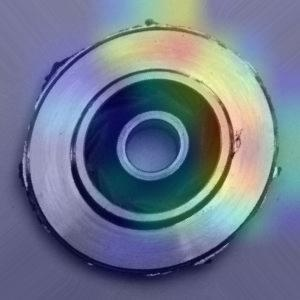

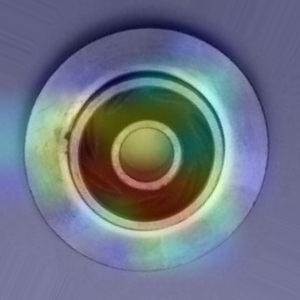

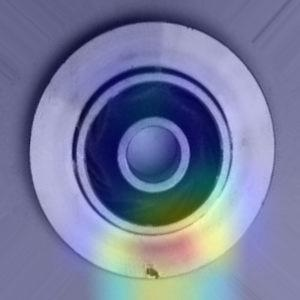

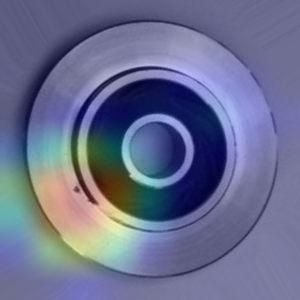

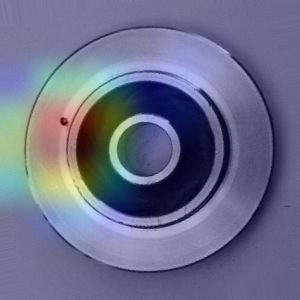

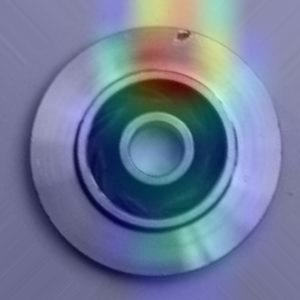

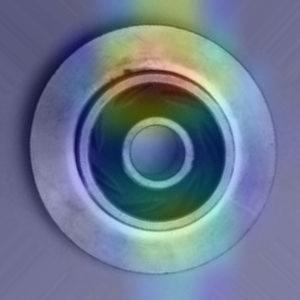

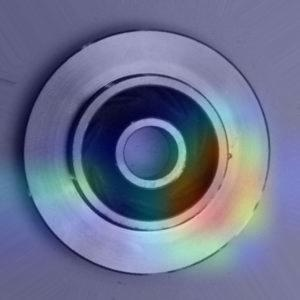

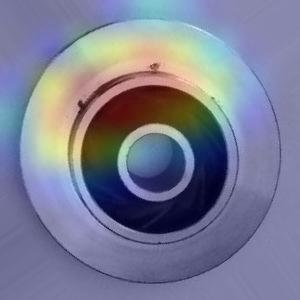

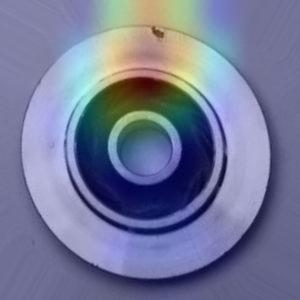

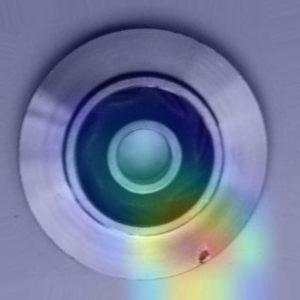

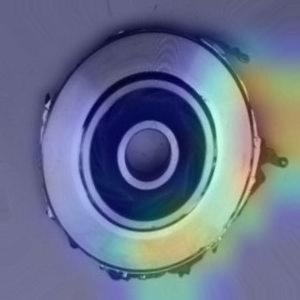

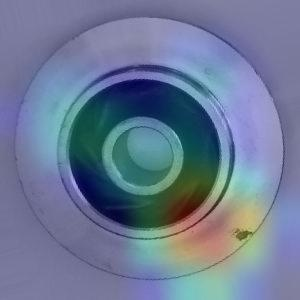

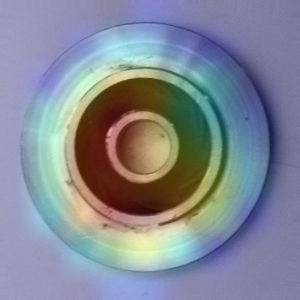

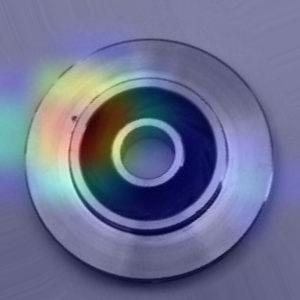

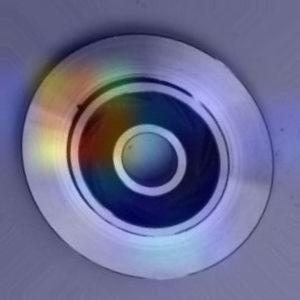

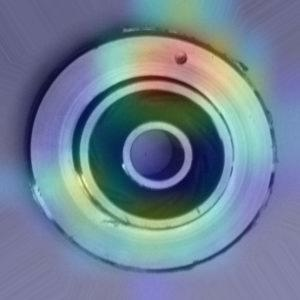

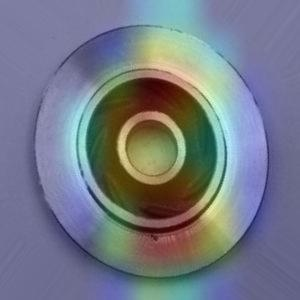

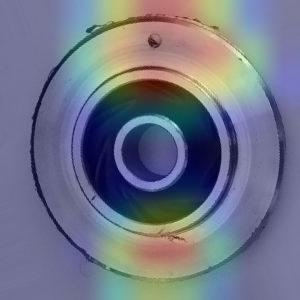

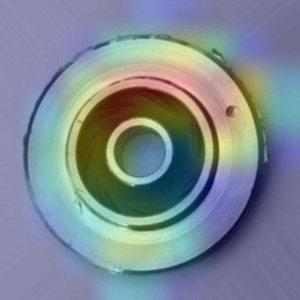

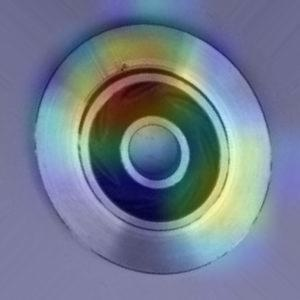

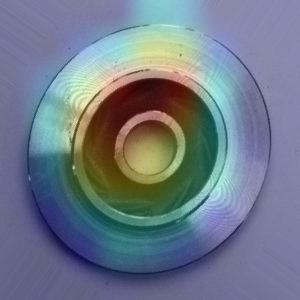

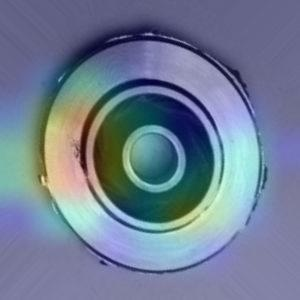

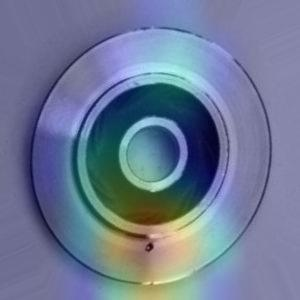

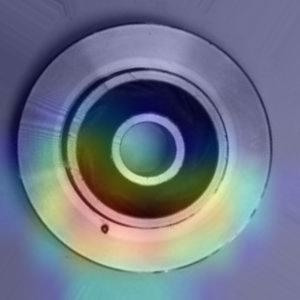

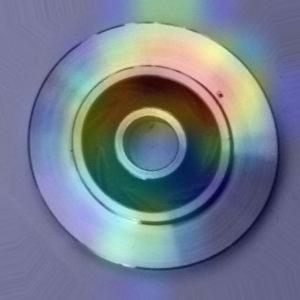

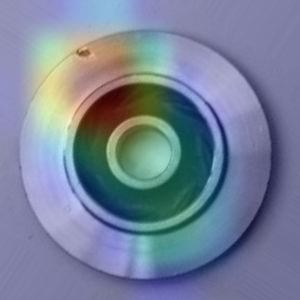

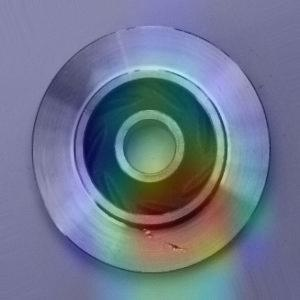

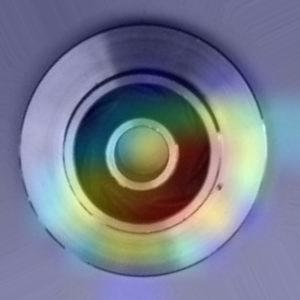

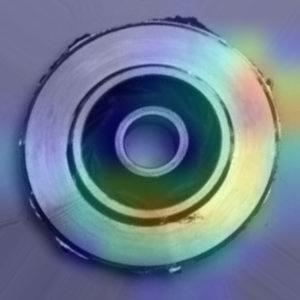

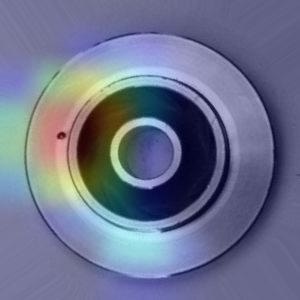

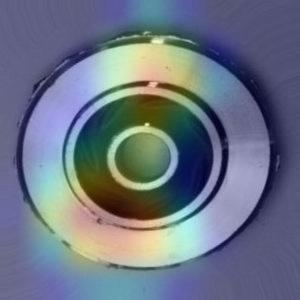

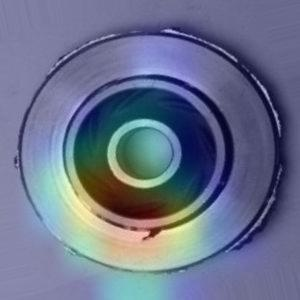

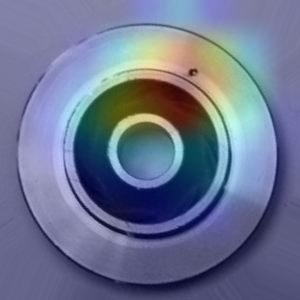

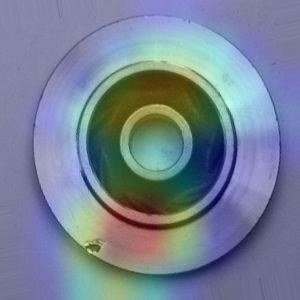

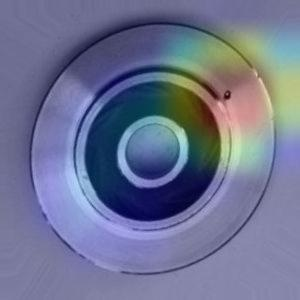

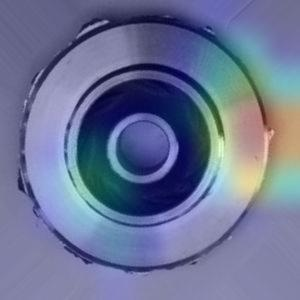

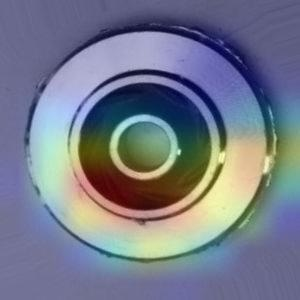

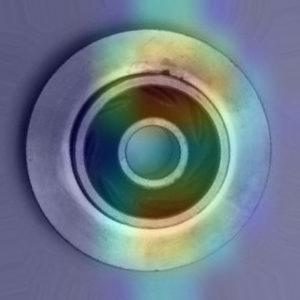

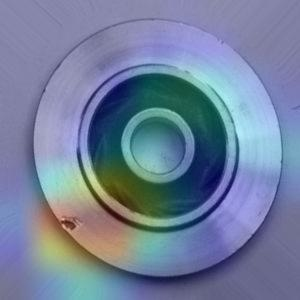

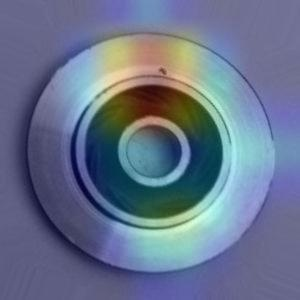

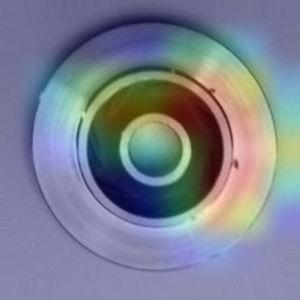

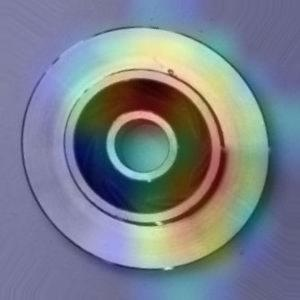

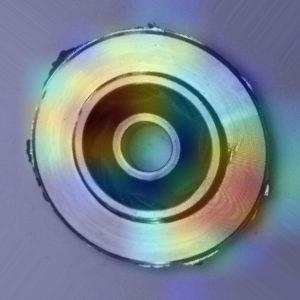

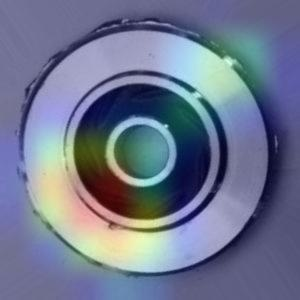

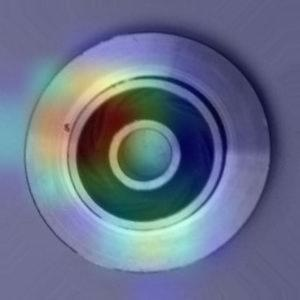

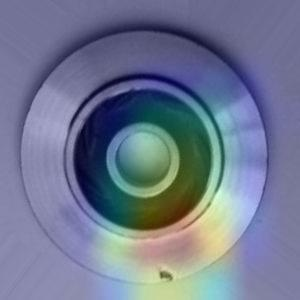

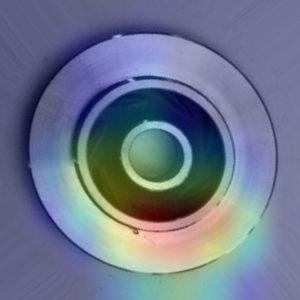

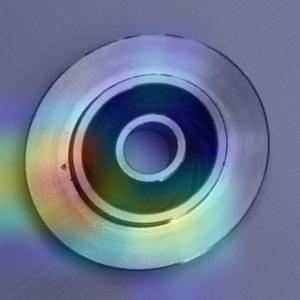

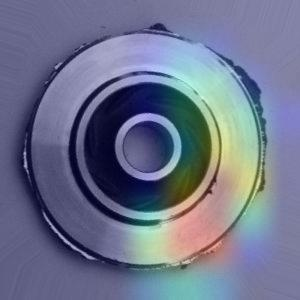

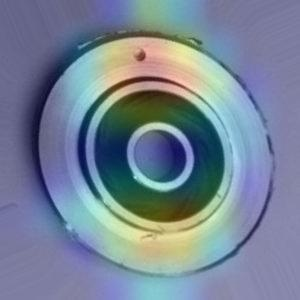

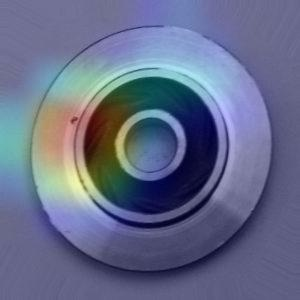

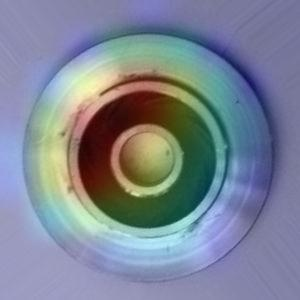

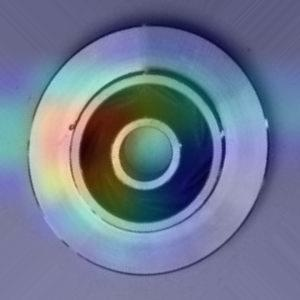

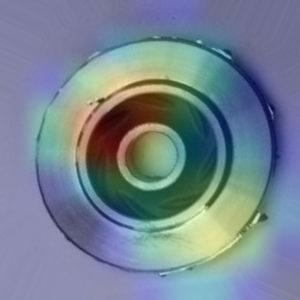

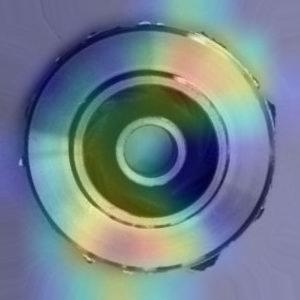

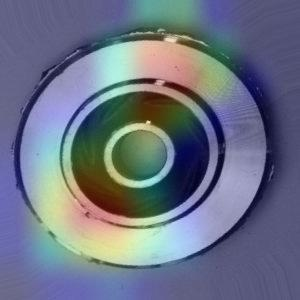

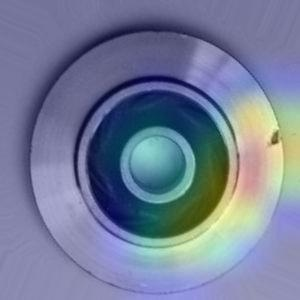

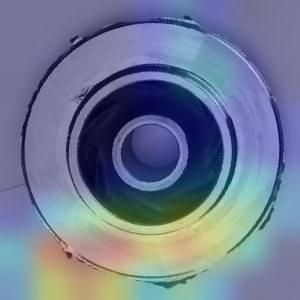

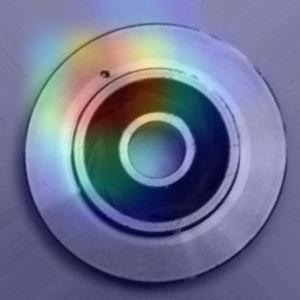

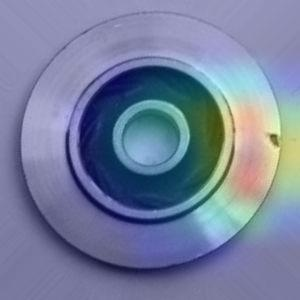

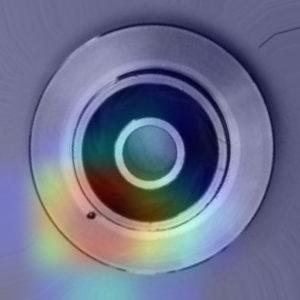

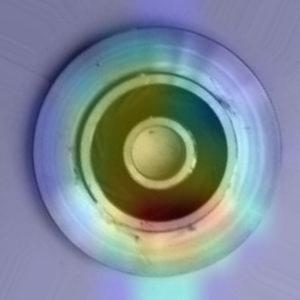

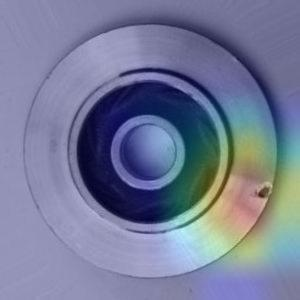

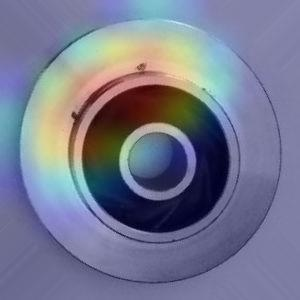

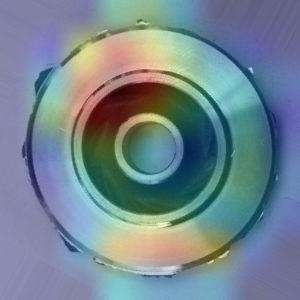

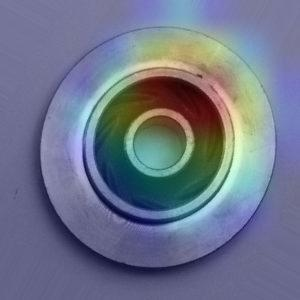

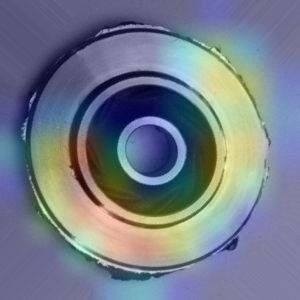

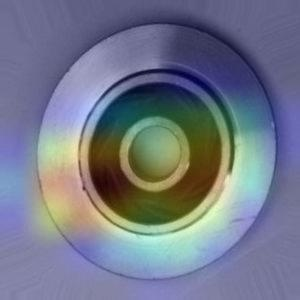

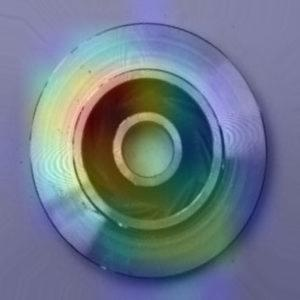

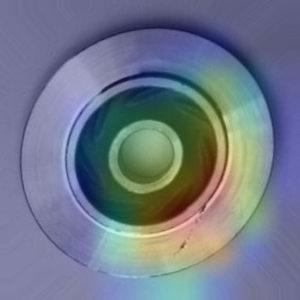

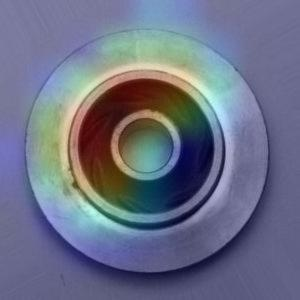

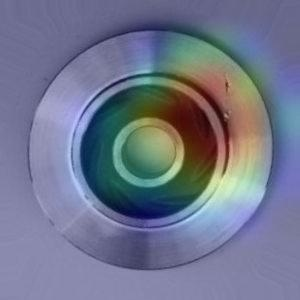

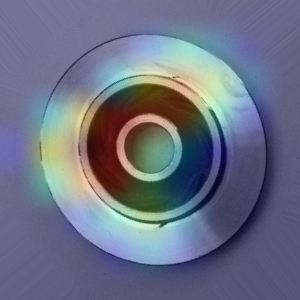

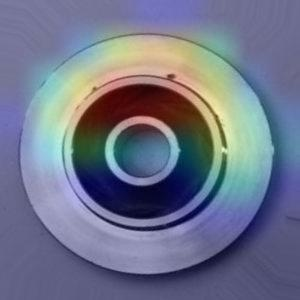

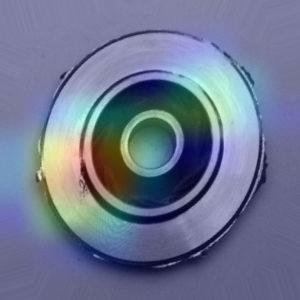

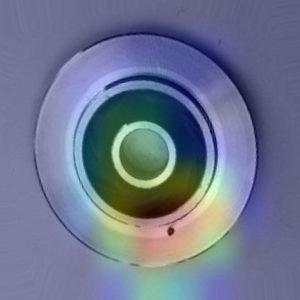

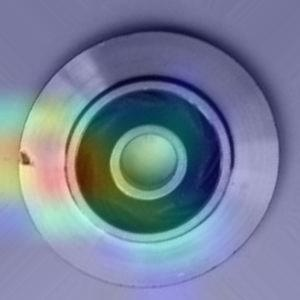

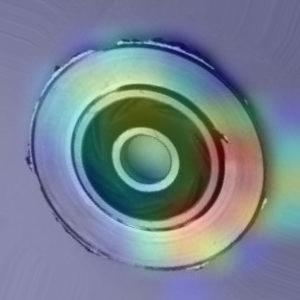

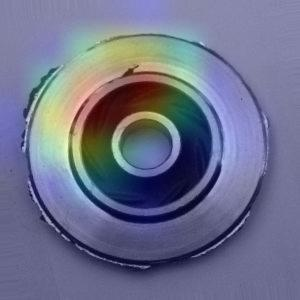

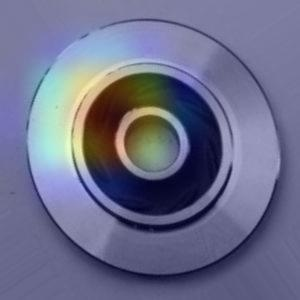

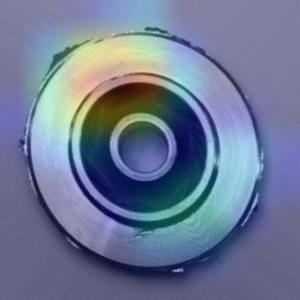

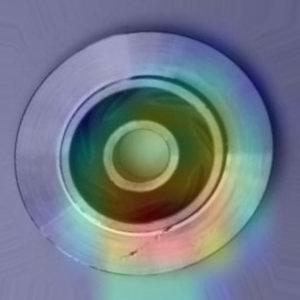

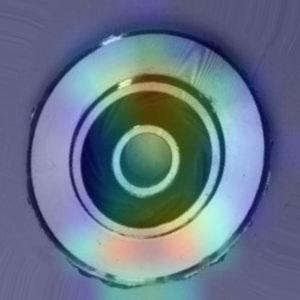

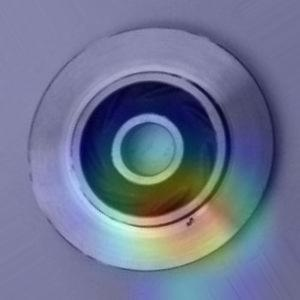

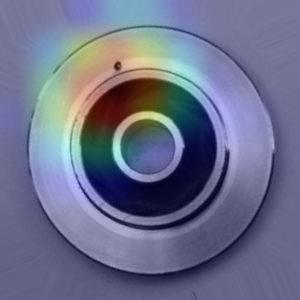

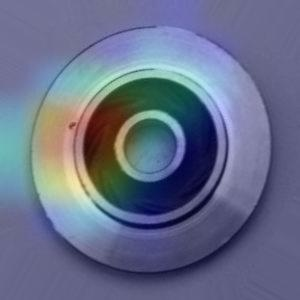

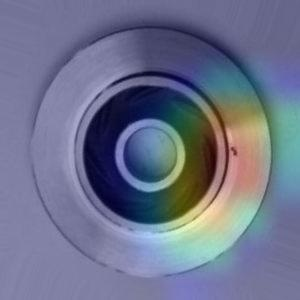

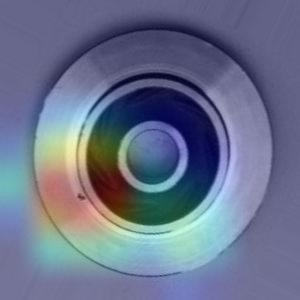

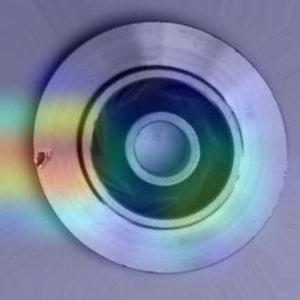

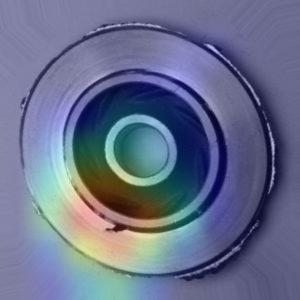

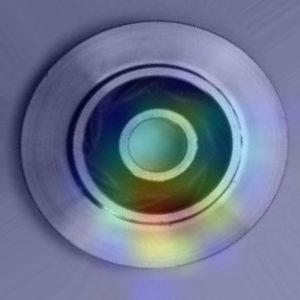

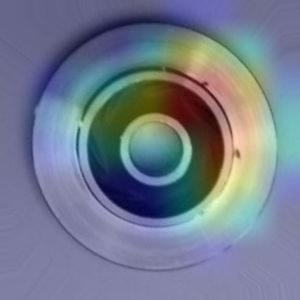

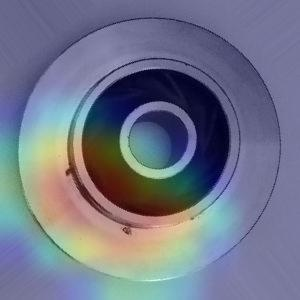

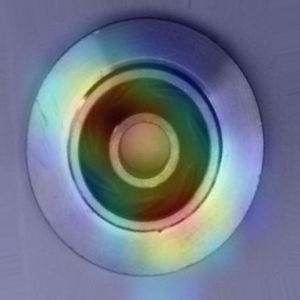

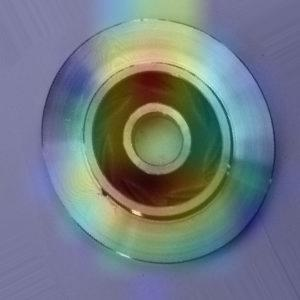

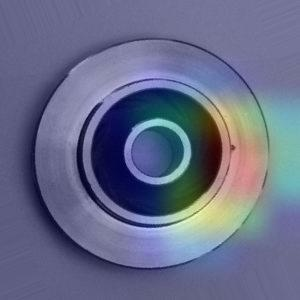

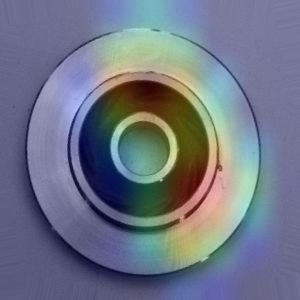

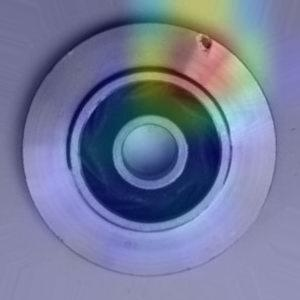

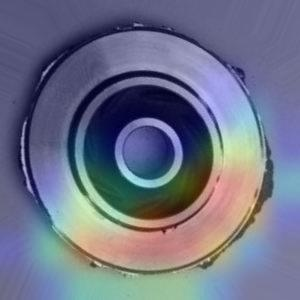

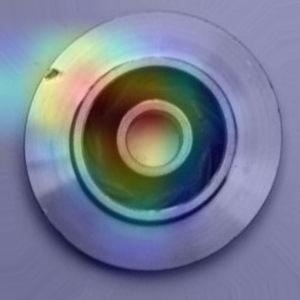

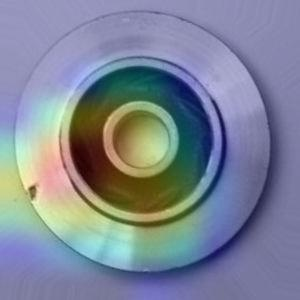

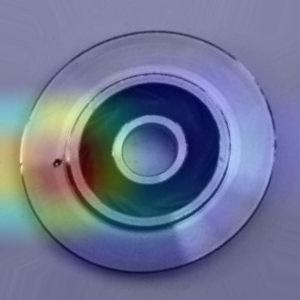

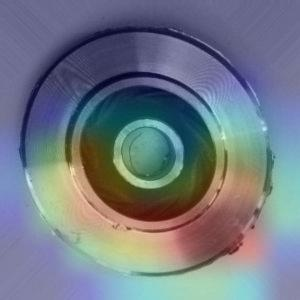

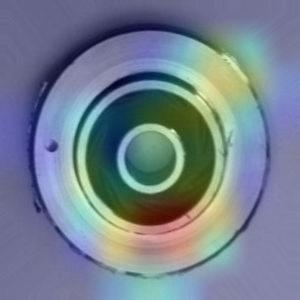

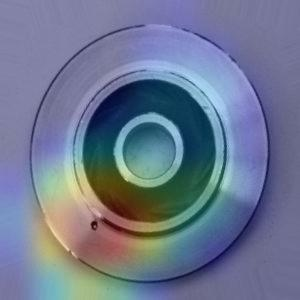

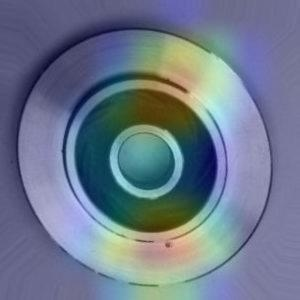

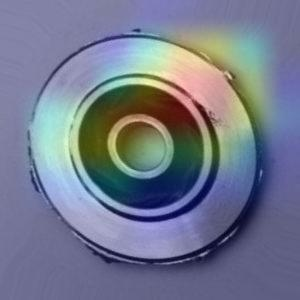

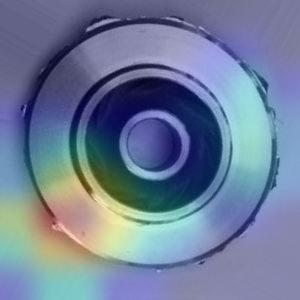

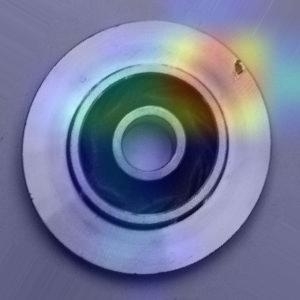

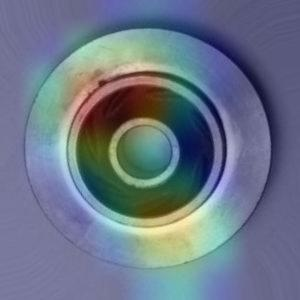

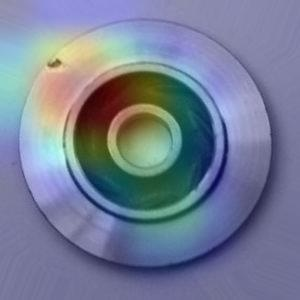

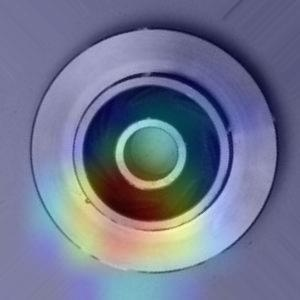

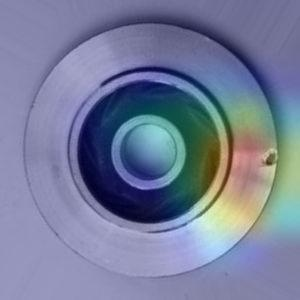

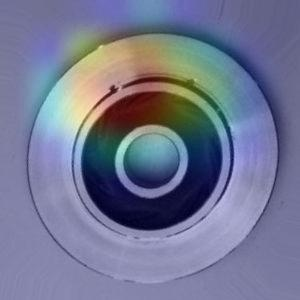

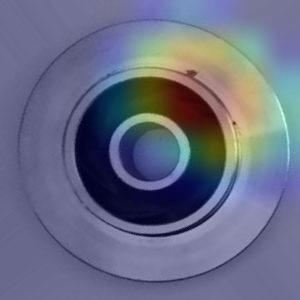

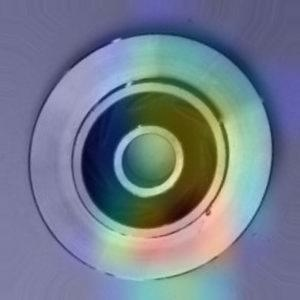

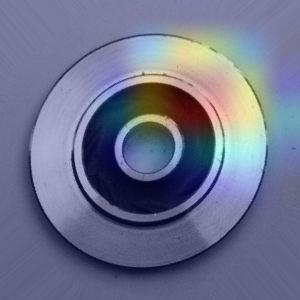

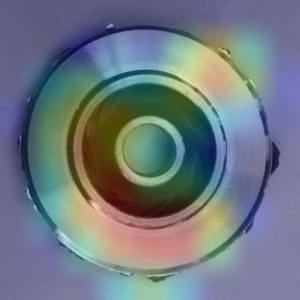

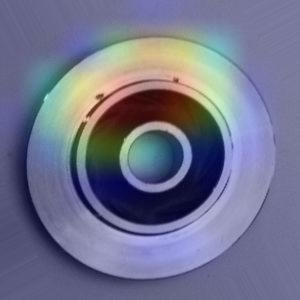

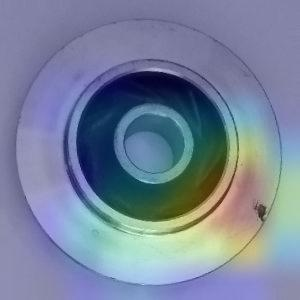

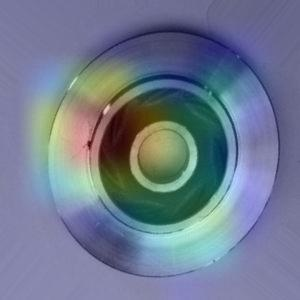

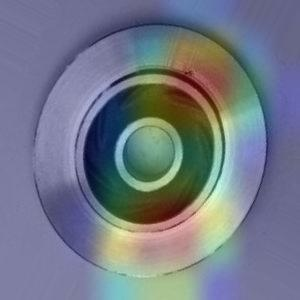

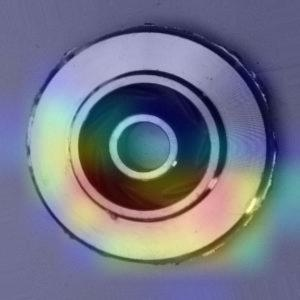

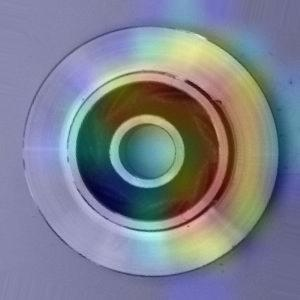

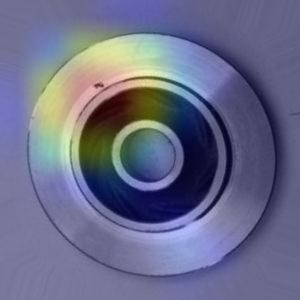

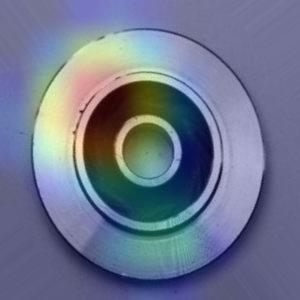

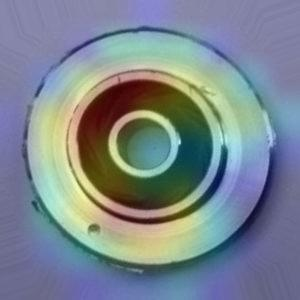

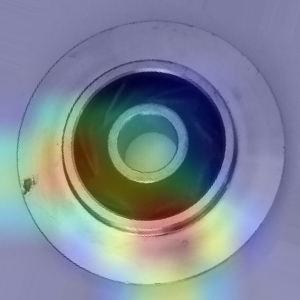

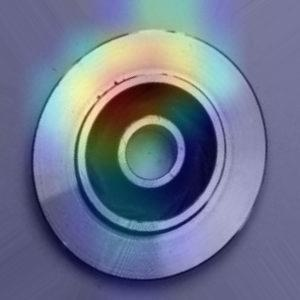

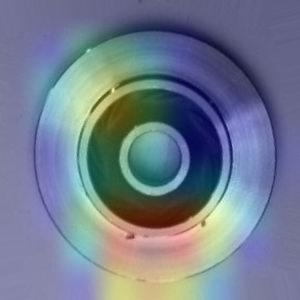

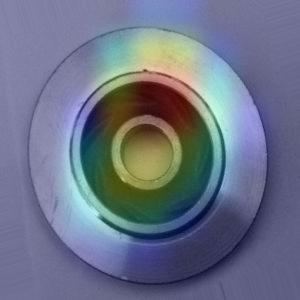

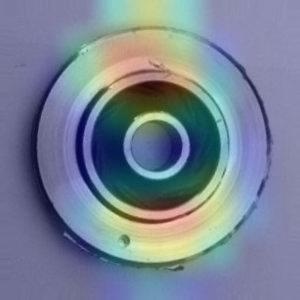

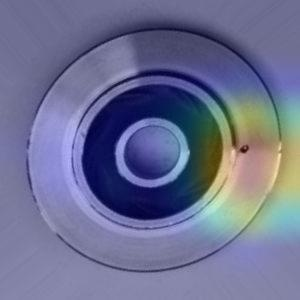

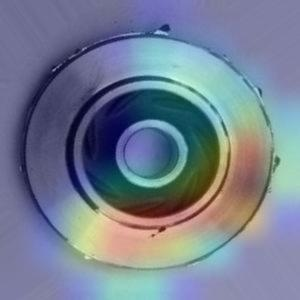

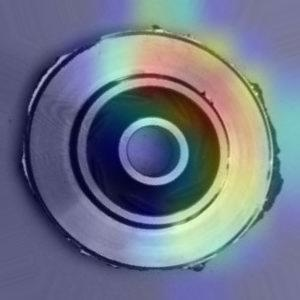

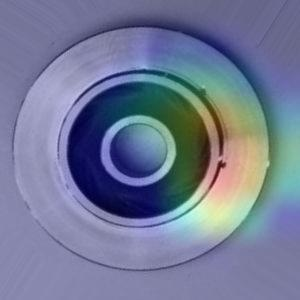

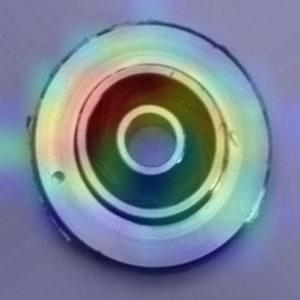

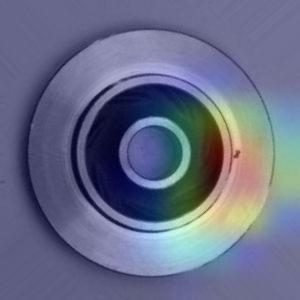

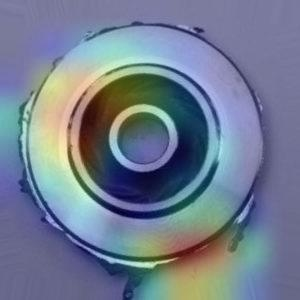

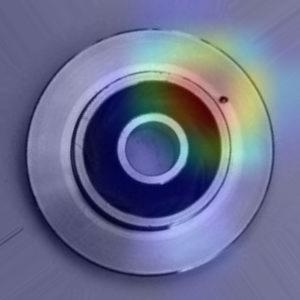

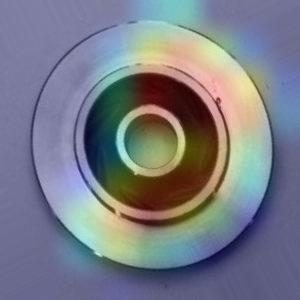

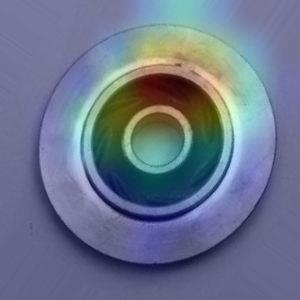

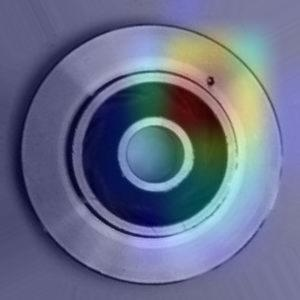

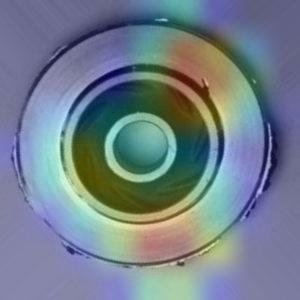

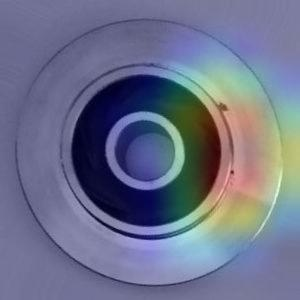

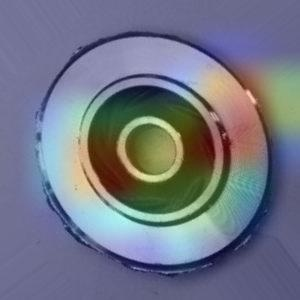

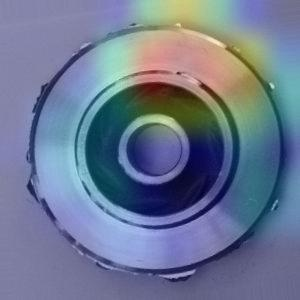

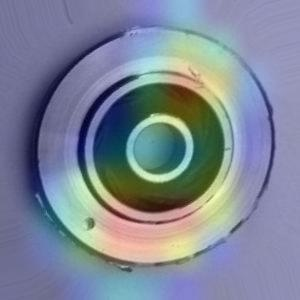

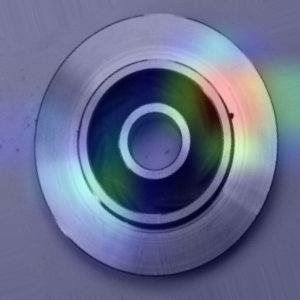

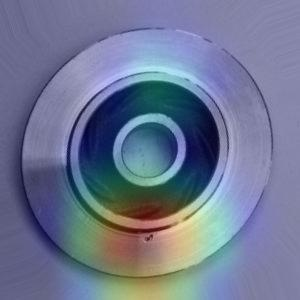

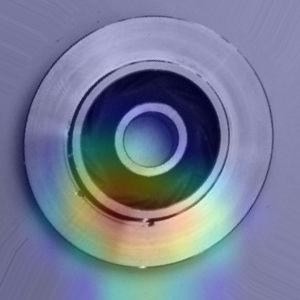

In [ ]:
!mkdir out_gradcam
m.layers[-1].activation = None
for path, directories, files in os.walk("/content/dataset/casting_data/casting_data/test/def_front"):
  for file in files:
    img_path = os.path.join(path, file)
    img_array = keras.applications.densenet.preprocess_input(get_img_array(img_path, size=(300,300)))
    heatmap = make_gradcam_heatmap(img_array, m, "relu")
    save_and_display_gradcam(img_path, heatmap, cam_path="/content/out_gradcam/" + file)

In [ ]:
!zip -r outgc.zip out_gradcam/

updating: out_gradcam/ (stored 0%)
  adding: out_gradcam/casting_data_test_cast_def_0_1607.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_7.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_1642.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_new__0_4483.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_485.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_150.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_2528.jpeg (deflated 1%)
  adding: out_gradcam/casting_data_test_cast_def_0_2308.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_504.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_2126.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_1493.jpeg (deflated 2%)
  adding: out_gradcam/casting_data_test_cast_def_0_3108.jpeg (deflated 1%)
  adding: out_gradcam/casting_data_test_cast_def_0_1500.jpeg (deflated 2%)
